In [264]:
# Set color scheme to colorblind-friendly palette and configure saving
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from datetime import datetime
sns.set(style='whitegrid')

# Create output directory for graphs
output_dir = 'visualization_outputs'
os.makedirs(output_dir, exist_ok=True)

# Configure matplotlib for high-quality outputs
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.facecolor'] = 'white'

# Use colorblind-friendly palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
sns.set_palette(colors)

# Function to save plots
def save_plot(filename, formats=['png', 'pdf', 'svg']):
    """Save current plot in multiple formats"""
    for fmt in formats:
        filepath = os.path.join(output_dir, f'{filename}.{fmt}')
        plt.savefig(filepath, format=fmt, dpi=300, bbox_inches='tight', facecolor='white')
    print(f'Saved: {filename}')

In [265]:
# Load hospital data
hospital1 = pd.read_csv('fakeHospital1_results.csv')
hospital2 = pd.read_csv('fakeHospital2_results.csv')

In [266]:
# Display data structure
print("Hospital 1 data:")
print(hospital1.head())
print("\nHospital 2 data:")
print(hospital2.head())

Hospital 1 data:
                       LLM  False Positives  False Negatives  \
0  qwen2.5vl3b*ImageInput*               31               30   
1              qwen2.5vl3b               24               32   
2              qwen2.5:72b               10                6   
3               llama3.21b                3               38   
4            llama-4-scout                7                8   

   Incorrect Extractions  Correct Matches  Precision     Recall    F1score  \
0                     13               40  56.338028  57.142857  56.737589   
1                     15               47  66.197183  59.493671  62.666667   
2                      1               73  87.951807  92.405063  90.123457   
3                      1               47  94.000000  55.294118  69.629630   
4                      1               74  91.358025  90.243902  90.797546   

    Accuracy      Source   Hospital  
0  45.454545      Ollama  hospital1  
1  53.409091      Ollama  hospital1  
2  82.954545  O

In [267]:
# Sort data by LLM name for consistency
hospital1.sort_values(by="LLM", inplace=True)
hospital2.sort_values(by="LLM", inplace=True)

## Combined Model Averages and Visualizations

In [268]:
# Function to normalize model names (combine image and non-image versions)
def normalize_model_name(llm_name):
    # Remove *ImageInput* suffix to combine with base model
    return llm_name.replace('*ImageInput*', '').strip()

# Create normalized versions of datasets for non-image-specific comparisons
hospital1_norm = hospital1.copy()
hospital2_norm = hospital2.copy()
hospital1_norm['LLM_normalized'] = hospital1_norm['LLM'].apply(normalize_model_name)
hospital2_norm['LLM_normalized'] = hospital2_norm['LLM'].apply(normalize_model_name)

# Group by normalized name and average the metrics
h1_grouped = hospital1_norm.groupby('LLM_normalized').agg({
    'False Positives': 'mean',
    'False Negatives': 'mean', 
    'Incorrect Extractions': 'mean',
    'Correct Matches': 'mean',
    'Precision': 'mean',
    'Recall': 'mean',
    'F1score': 'mean',
    'Accuracy': 'mean',
    'Source': 'first'
}).reset_index()
h1_grouped['Hospital'] = 'Hospital1'

h2_grouped = hospital2_norm.groupby('LLM_normalized').agg({
    'False Positives': 'mean',
    'False Negatives': 'mean',
    'Incorrect Extractions': 'mean', 
    'Correct Matches': 'mean',
    'Precision': 'mean',
    'Recall': 'mean',
    'F1score': 'mean',
    'Accuracy': 'mean',
    'Source': 'first'
}).reset_index()
h2_grouped['Hospital'] = 'Hospital2'

# Combined normalized data
all_normalized = pd.concat([h1_grouped, h2_grouped], ignore_index=True)
print(f"Normalized dataset: {len(all_normalized)} records")

Normalized dataset: 22 records


In [269]:
# Combine data from both hospitals and compute averages (original method)
merged = pd.merge(
    hospital1.drop(columns = ["Hospital"], errors='ignore'), 
    hospital2.drop(columns = ["Hospital"], errors='ignore'),
    on=["LLM", "Source"], 
    how='inner' 
)
combined = merged[['LLM', 'Source']].copy()
combined['False Positives'] = merged[['False Positives_x', 'False Positives_y']].mean(axis=1)
combined['False Negatives'] = merged[['False Negatives_x', 'False Negatives_y']].mean(axis=1)
combined['Incorrect Extractions'] = merged[['Incorrect Extractions_x', 'Incorrect Extractions_y']].mean(axis=1)
combined['Correct Matches'] = merged[['Correct Matches_x', 'Correct Matches_y']].mean(axis=1)
combined['Accuracy'] = merged[['Accuracy_x', 'Accuracy_y']].mean(axis=1)
combined['F1score'] = merged[['F1score_x', 'F1score_y']].mean(axis=1)
combined['Precision'] = merged[['Precision_x', 'Precision_y']].mean(axis=1)
combined['Recall'] = merged[['Recall_x', 'Recall_y']].mean(axis=1)
print(f"Combined dataset has {len(combined)} models")
combined.head(10)

Combined dataset has 14 models


,LLM,Source,False Positives,False Negatives,Incorrect Extractions,Correct Matches,Accuracy,F1score,Precision,Recall
0,devstral-small,OpenRouter,14.0,10.0,8.5,72.5,82.386364,85.692766,83.854584,87.776304
1,gemini-2.0,OpenRouter,11.5,11.0,5.0,70.5,80.113636,86.206510,85.922619,86.532671
2,gemma31b-it-qat,Ollama,10.0,26.5,6.5,58.0,65.909091,76.075546,85.290937,68.664144
3,gemma34b*ImageInput*,Ollama,31.0,46.0,25.0,36.0,40.909091,48.808234,54.046823,44.514107
4,gpt-4.1-nano,OpenAI,15.0,28.5,8.5,53.0,60.227273,70.908277,78.256143,65.411373
5,gpt-4.1-nano*ImageInput*,OpenAi,2.5,39.0,2.5,48.0,54.545455,69.708995,94.791667,55.172414
6,gpt-4o-mini,OpenAI,15.0,27.0,8.5,54.5,61.931818,72.241962,78.435035,67.385057
7,gpt-4o-mini*ImageInput*,OpenAi,1.0,39.0,0.0,47.0,53.409091,69.968211,97.893813,54.651163
8,granite3.32b,Ollama,23.0,32.0,7.0,39.5,44.886364,55.920904,62.410348,51.254590
9,llama-4-scout,OpenRouter,47.5,48.0,44.5,37.0,42.045455,45.398773,45.679012,45.121951


Saved: 01_accuracy_distribution_normalized


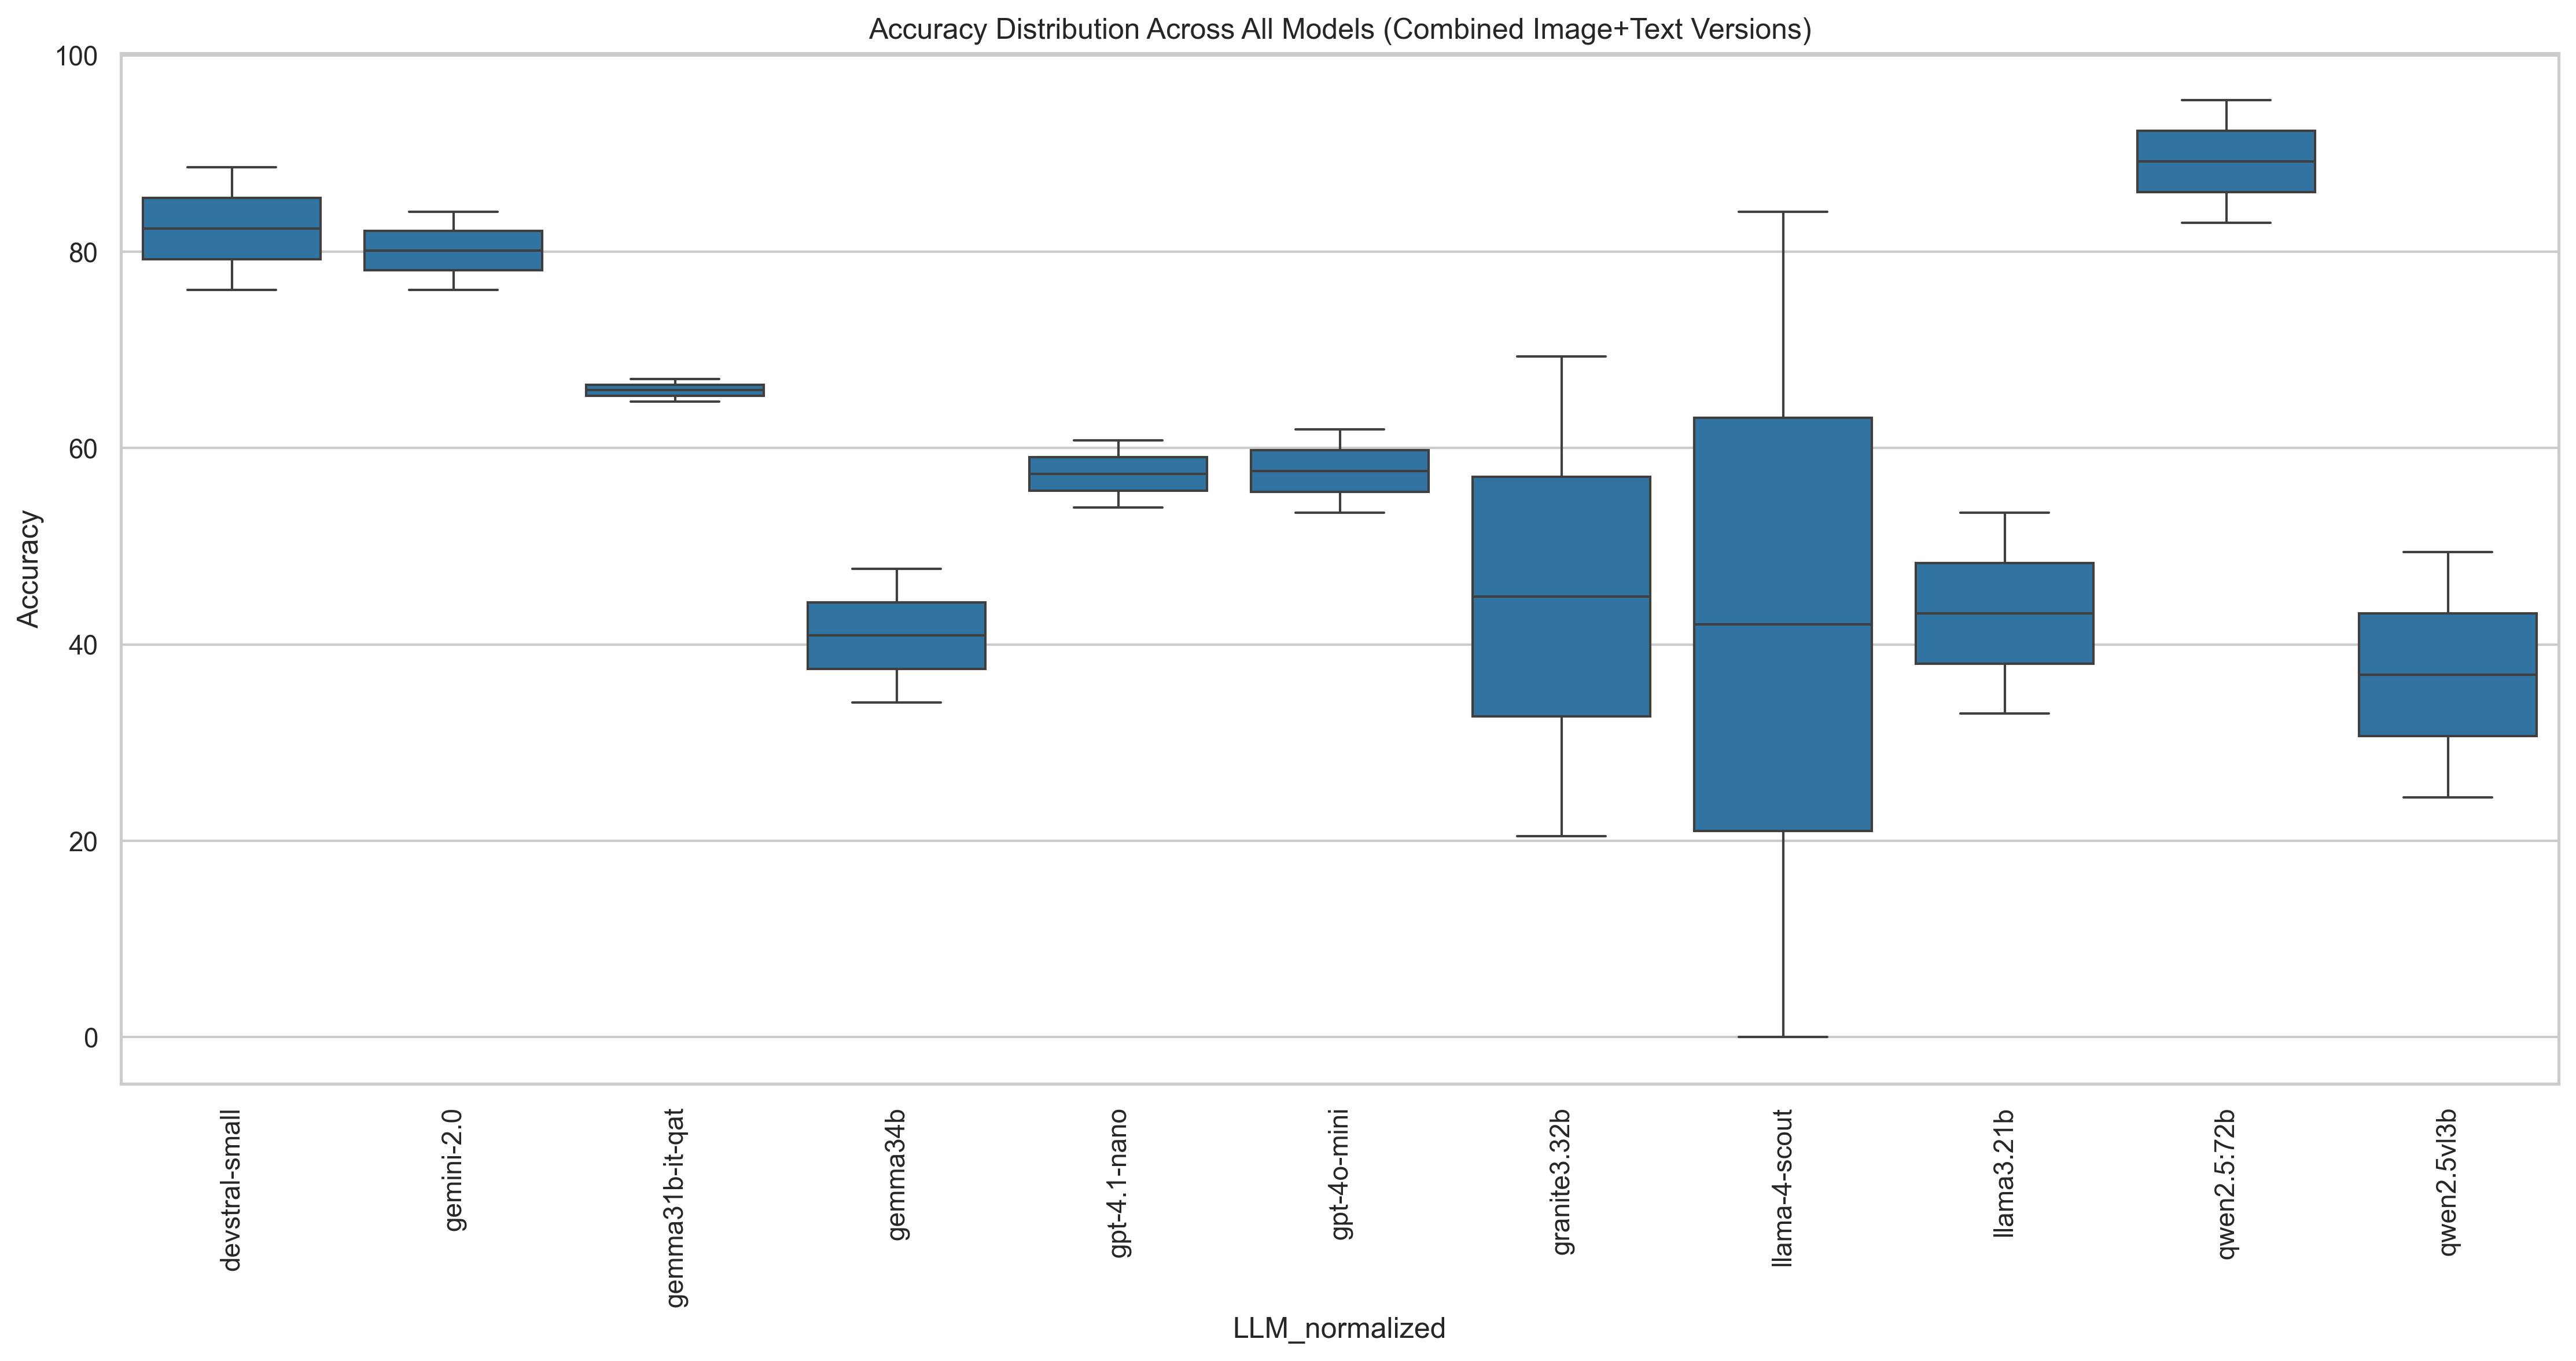

In [270]:
# Box-and-whisker plot for Accuracy across models (using normalized data)
plt.figure(figsize=(15,8))
sns.boxplot(data=all_normalized, x='LLM_normalized', y='Accuracy')
plt.xticks(rotation=90)
plt.title('Accuracy Distribution Across All Models (Combined Image+Text Versions)')
plt.tight_layout()
save_plot('01_accuracy_distribution_normalized')
plt.show()

Saved: 02_f1_score_hospital_comparison_normalized


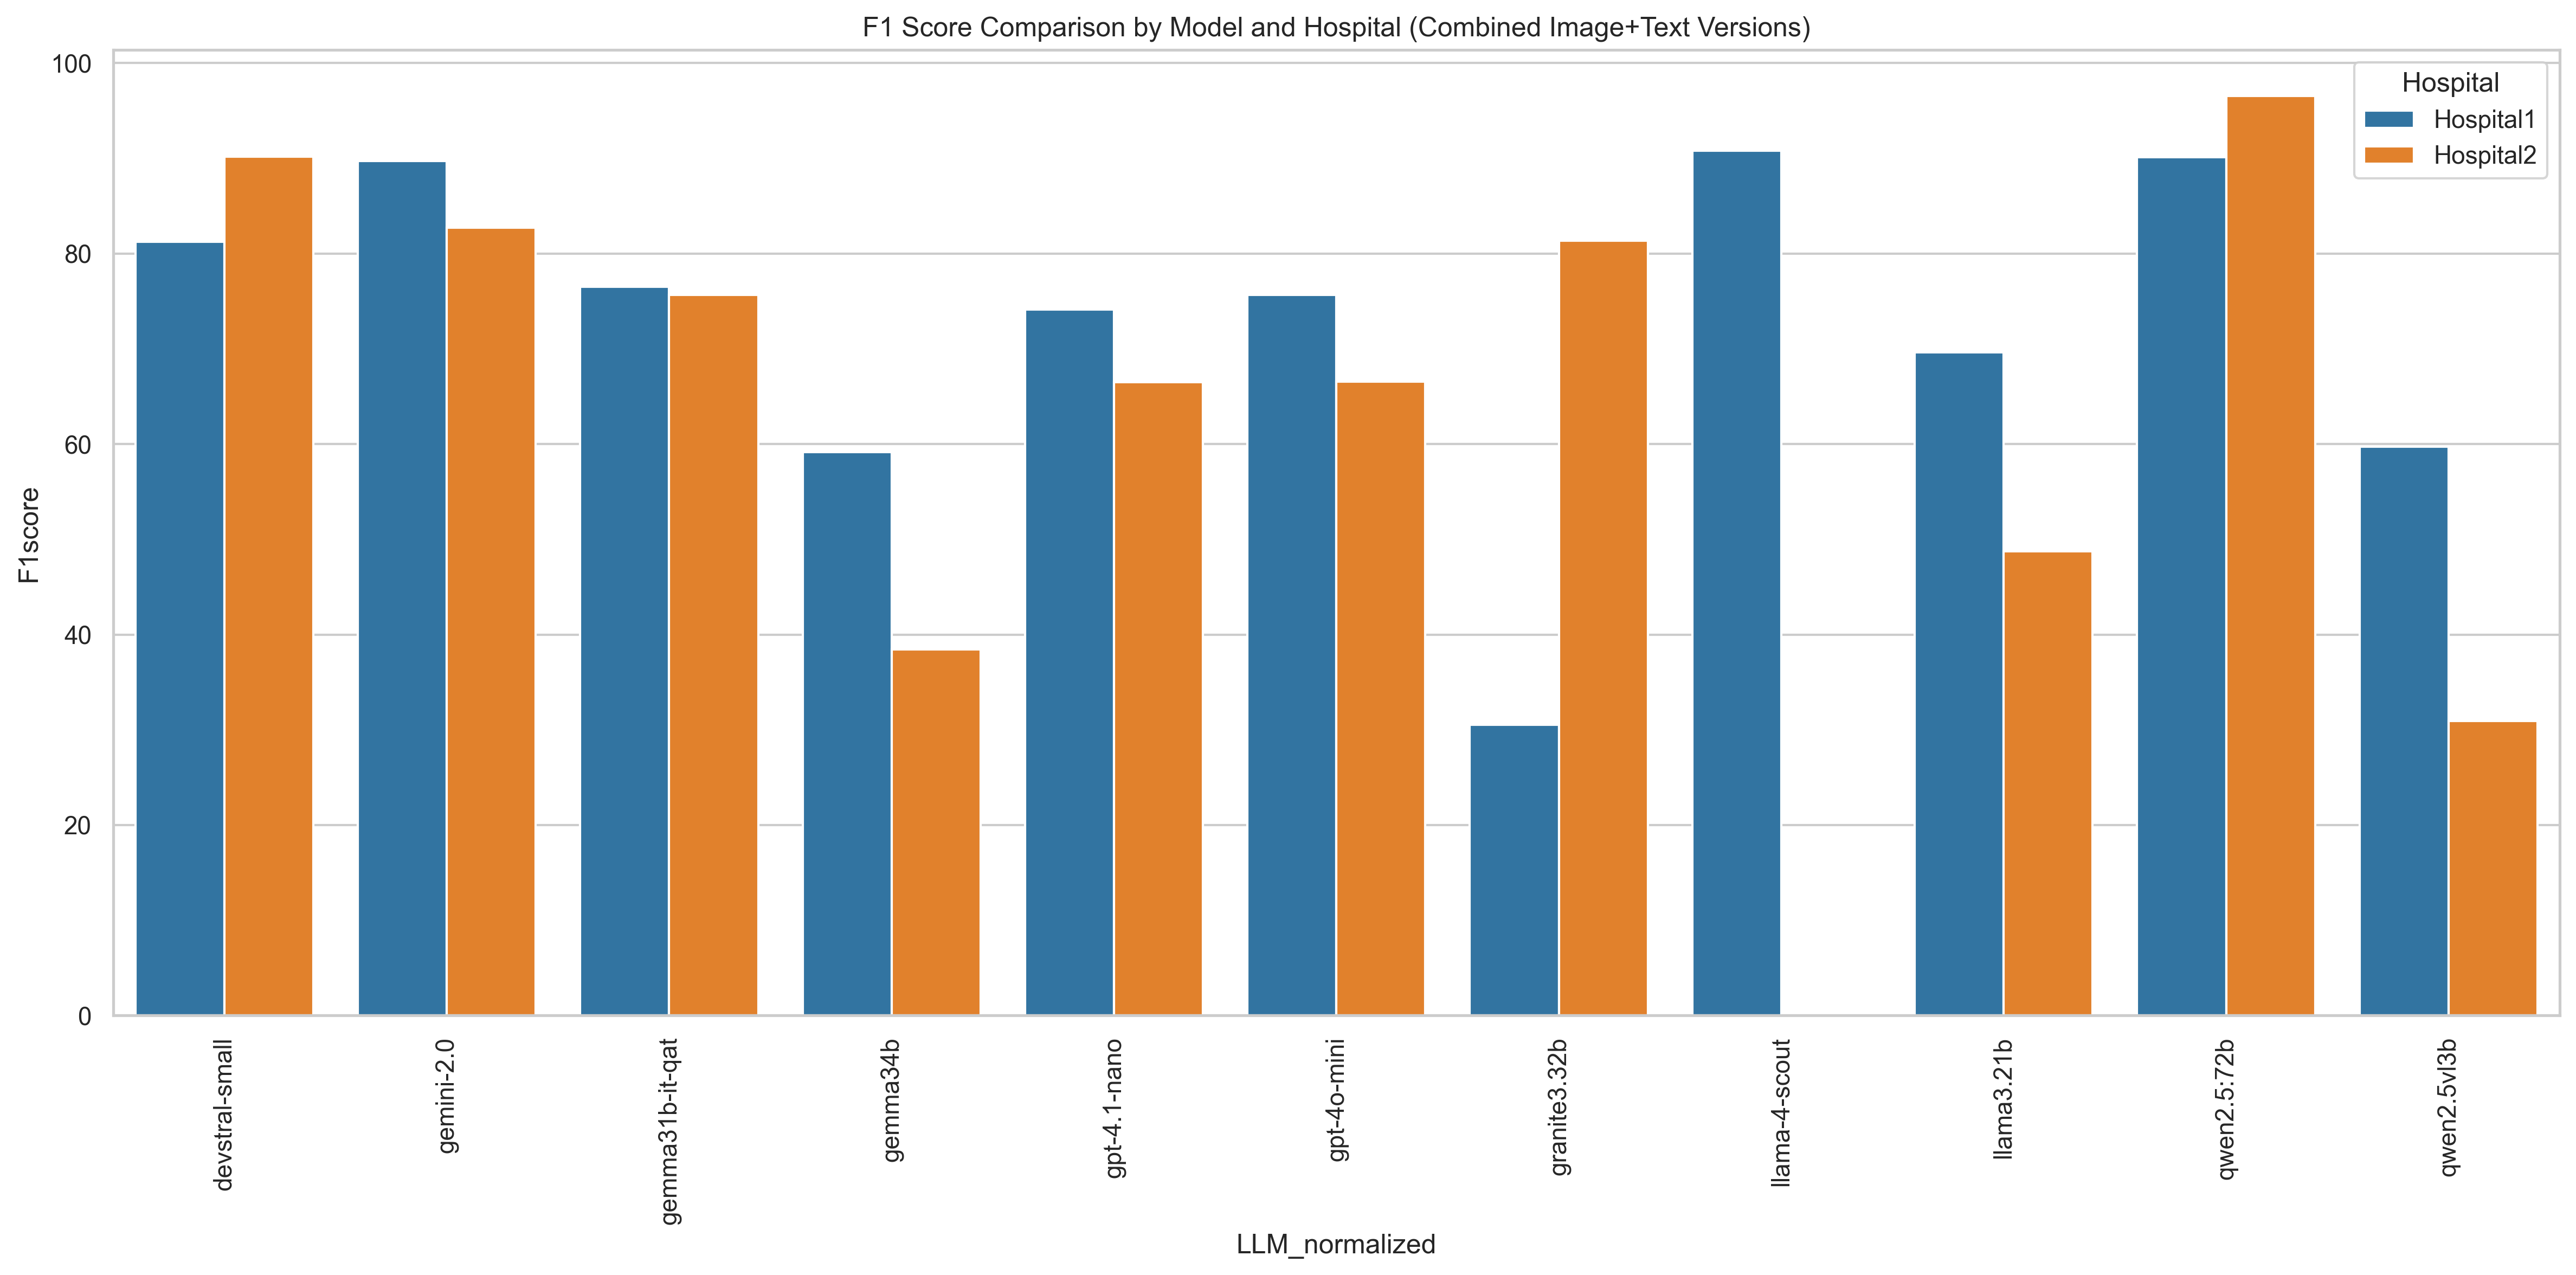

In [271]:
# Bar chart comparing F1 Score between hospitals (using normalized data)
plt.figure(figsize=(16,8))
sns.barplot(data=all_normalized, x='LLM_normalized', y='F1score', hue='Hospital')
plt.xticks(rotation=90)
plt.title('F1 Score Comparison by Model and Hospital (Combined Image+Text Versions)')
plt.tight_layout()
save_plot('02_f1_score_hospital_comparison_normalized')
plt.show()

Saved: 03_false_positives_negatives_comparison


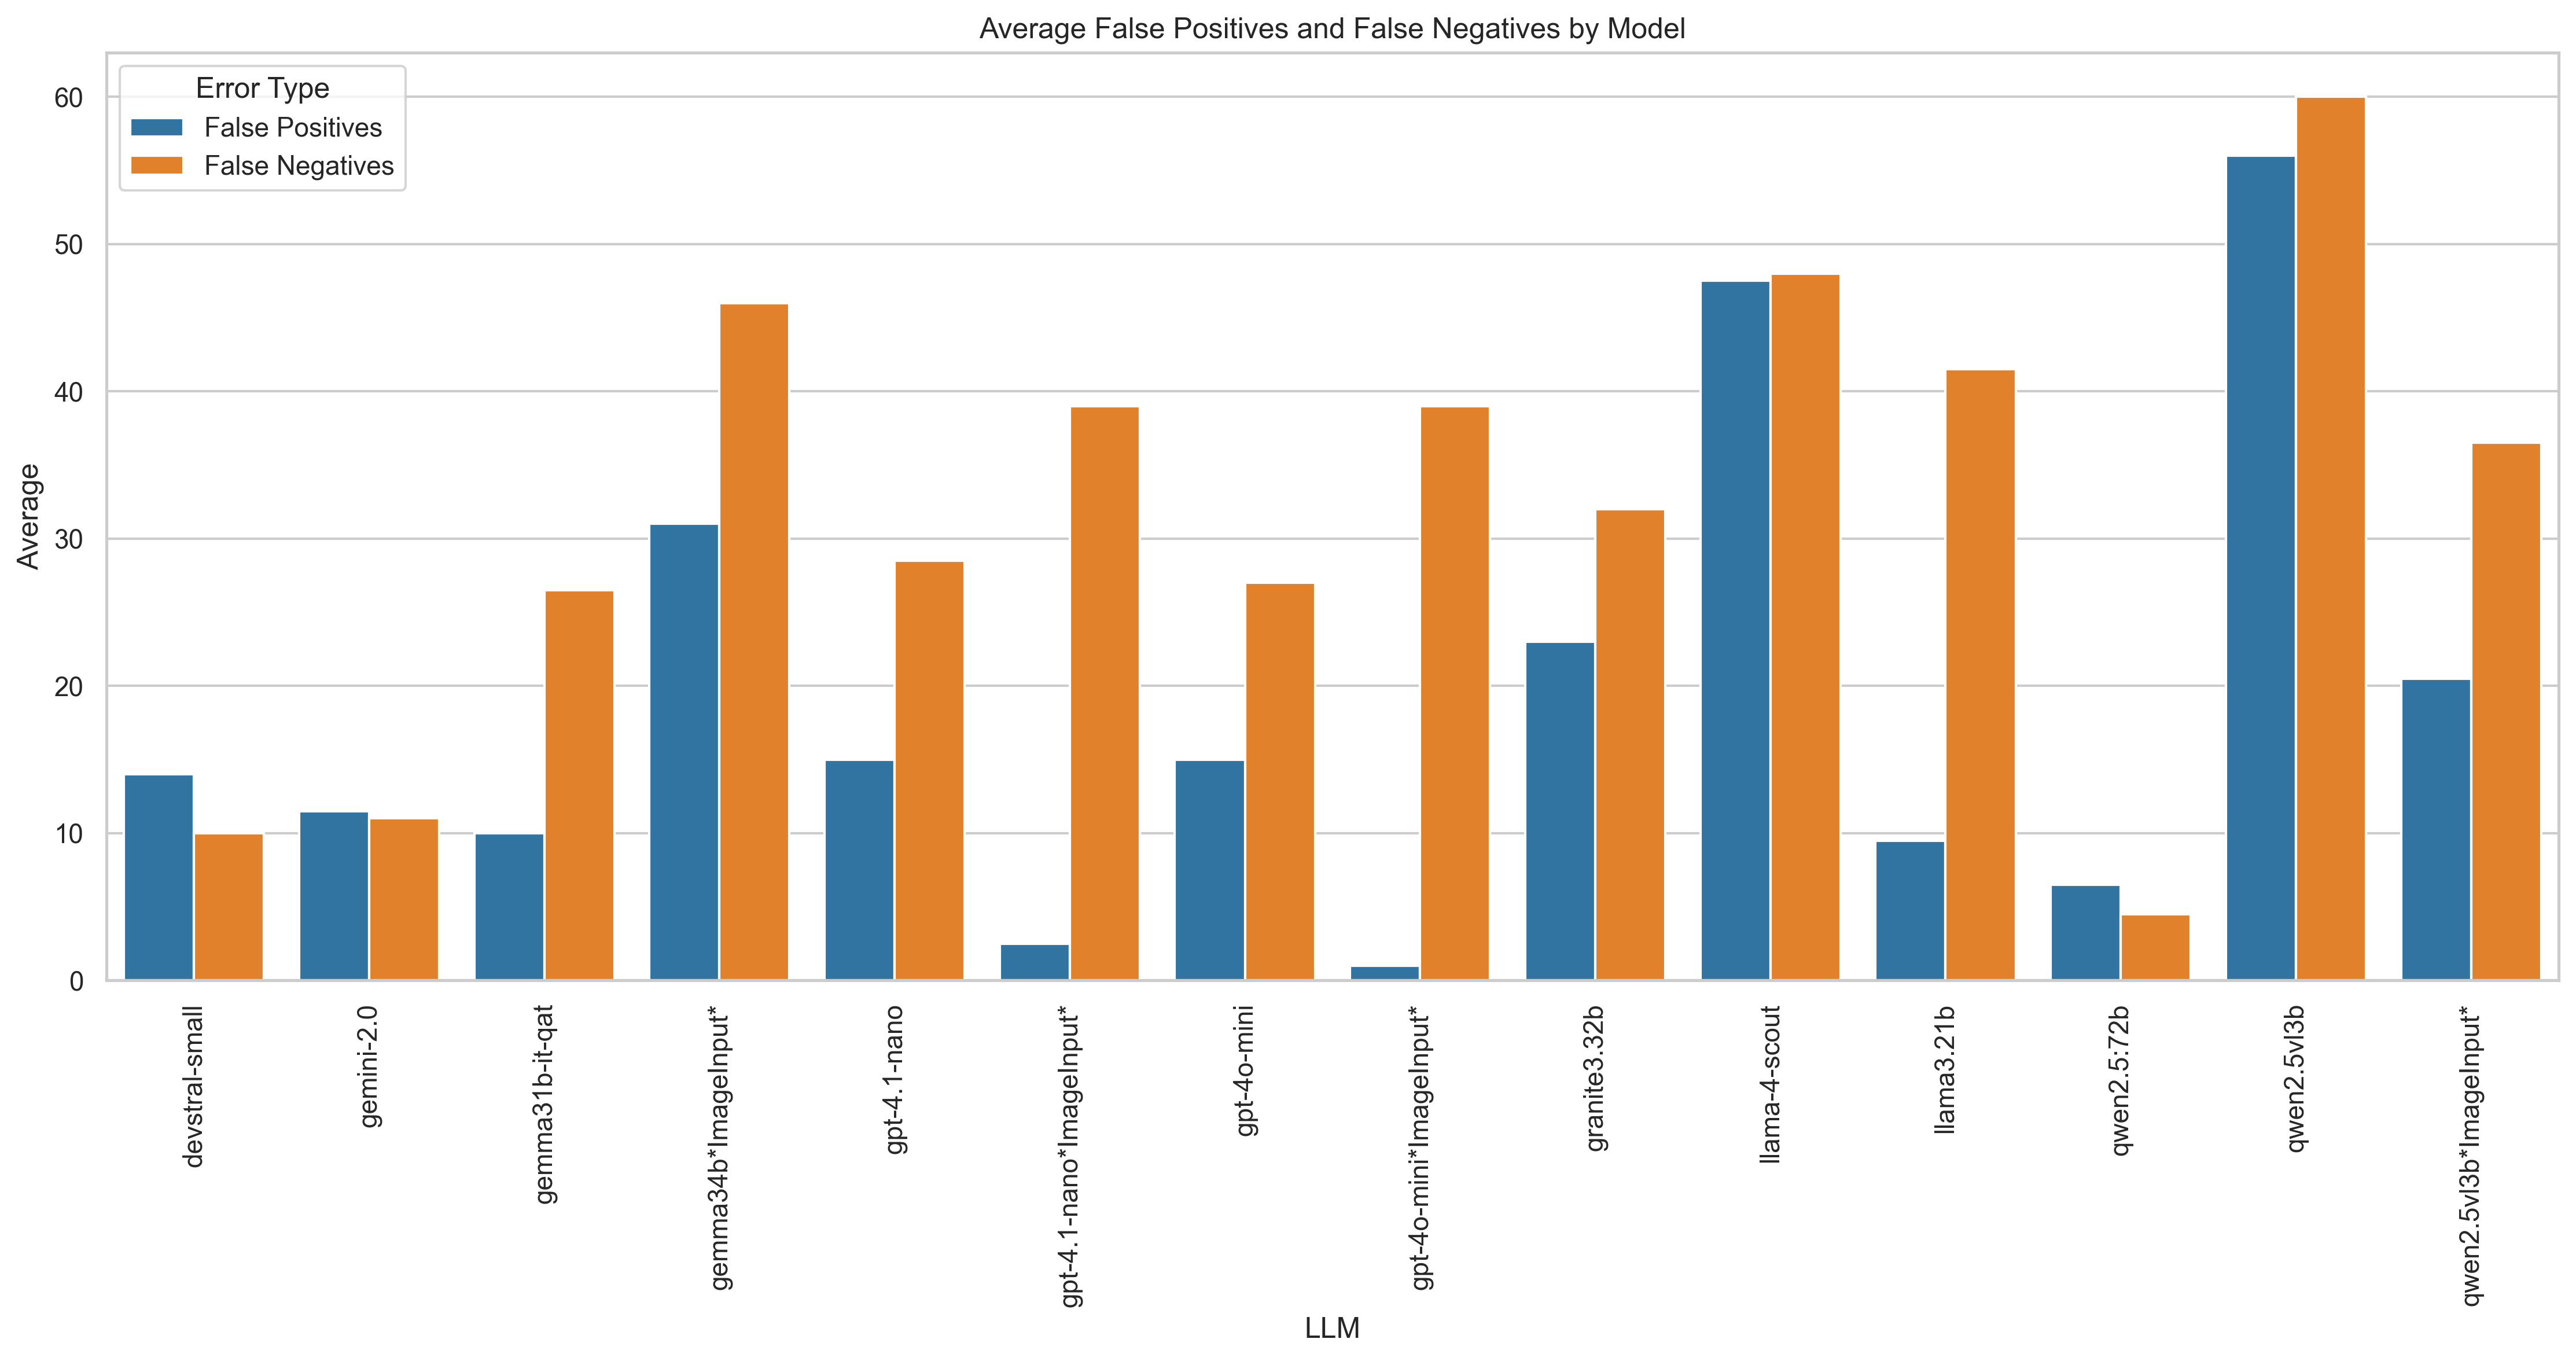

In [272]:
# Bar chart for average False Positives and False Negatives
melted = combined.melt(id_vars='LLM', value_vars=['False Positives','False Negatives'], var_name='Error Type', value_name='Average')
plt.figure(figsize=(15,8))
sns.barplot(data=melted, x='LLM', y='Average', hue='Error Type')
plt.xticks(rotation=90)
plt.title('Average False Positives and False Negatives by Model')
plt.tight_layout()
save_plot('03_false_positives_negatives_comparison')
plt.show()

Saved: 04_image_input_vs_no_image_comparison


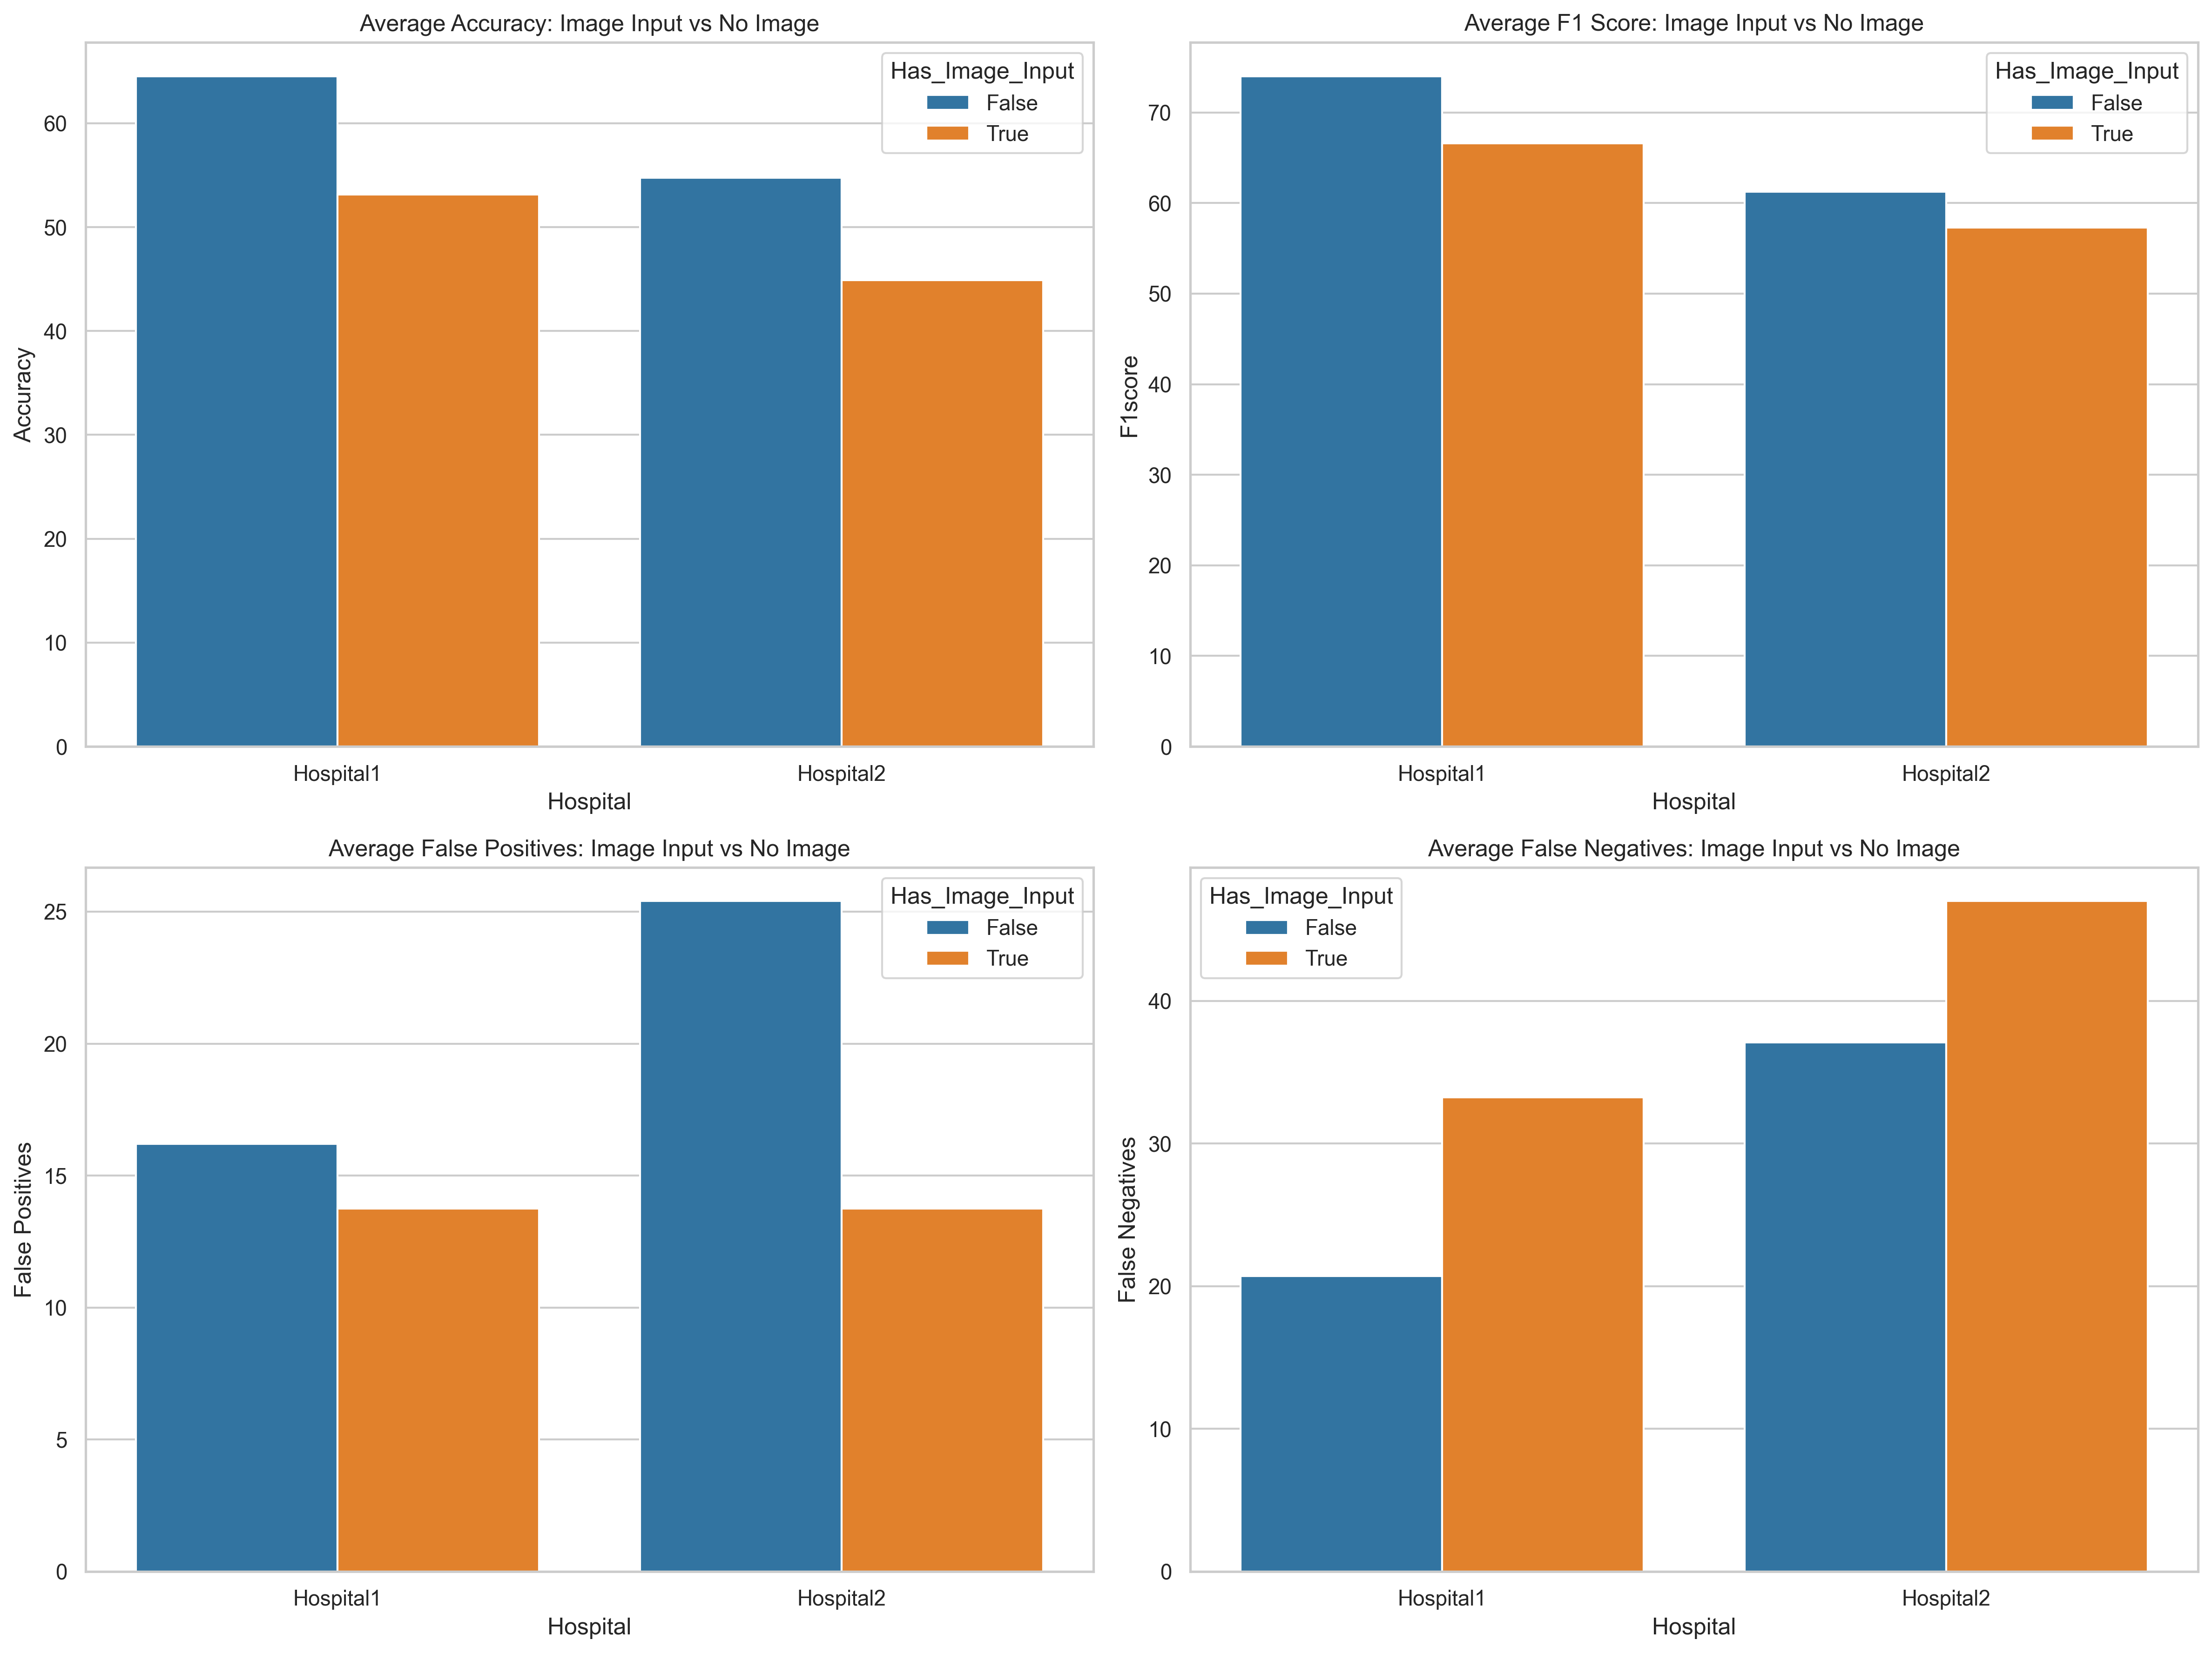

In [273]:
# Comparison between models with and without image input
all_individual['Has_Image_Input'] = all_individual['LLM'].str.contains('ImageInput', case=False)
img_comparison = all_individual.groupby(['Hospital', 'Has_Image_Input']).agg({
    'Accuracy': 'mean',
    'F1score': 'mean',
    'False Positives': 'mean',
    'False Negatives': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.barplot(data=img_comparison, x='Hospital', y='Accuracy', hue='Has_Image_Input', ax=axes[0,0])
axes[0,0].set_title('Average Accuracy: Image Input vs No Image')

sns.barplot(data=img_comparison, x='Hospital', y='F1score', hue='Has_Image_Input', ax=axes[0,1])
axes[0,1].set_title('Average F1 Score: Image Input vs No Image')

sns.barplot(data=img_comparison, x='Hospital', y='False Positives', hue='Has_Image_Input', ax=axes[1,0])
axes[1,0].set_title('Average False Positives: Image Input vs No Image')

sns.barplot(data=img_comparison, x='Hospital', y='False Negatives', hue='Has_Image_Input', ax=axes[1,1])
axes[1,1].set_title('Average False Negatives: Image Input vs No Image')

plt.tight_layout()
save_plot('04_image_input_vs_no_image_comparison')
plt.show()

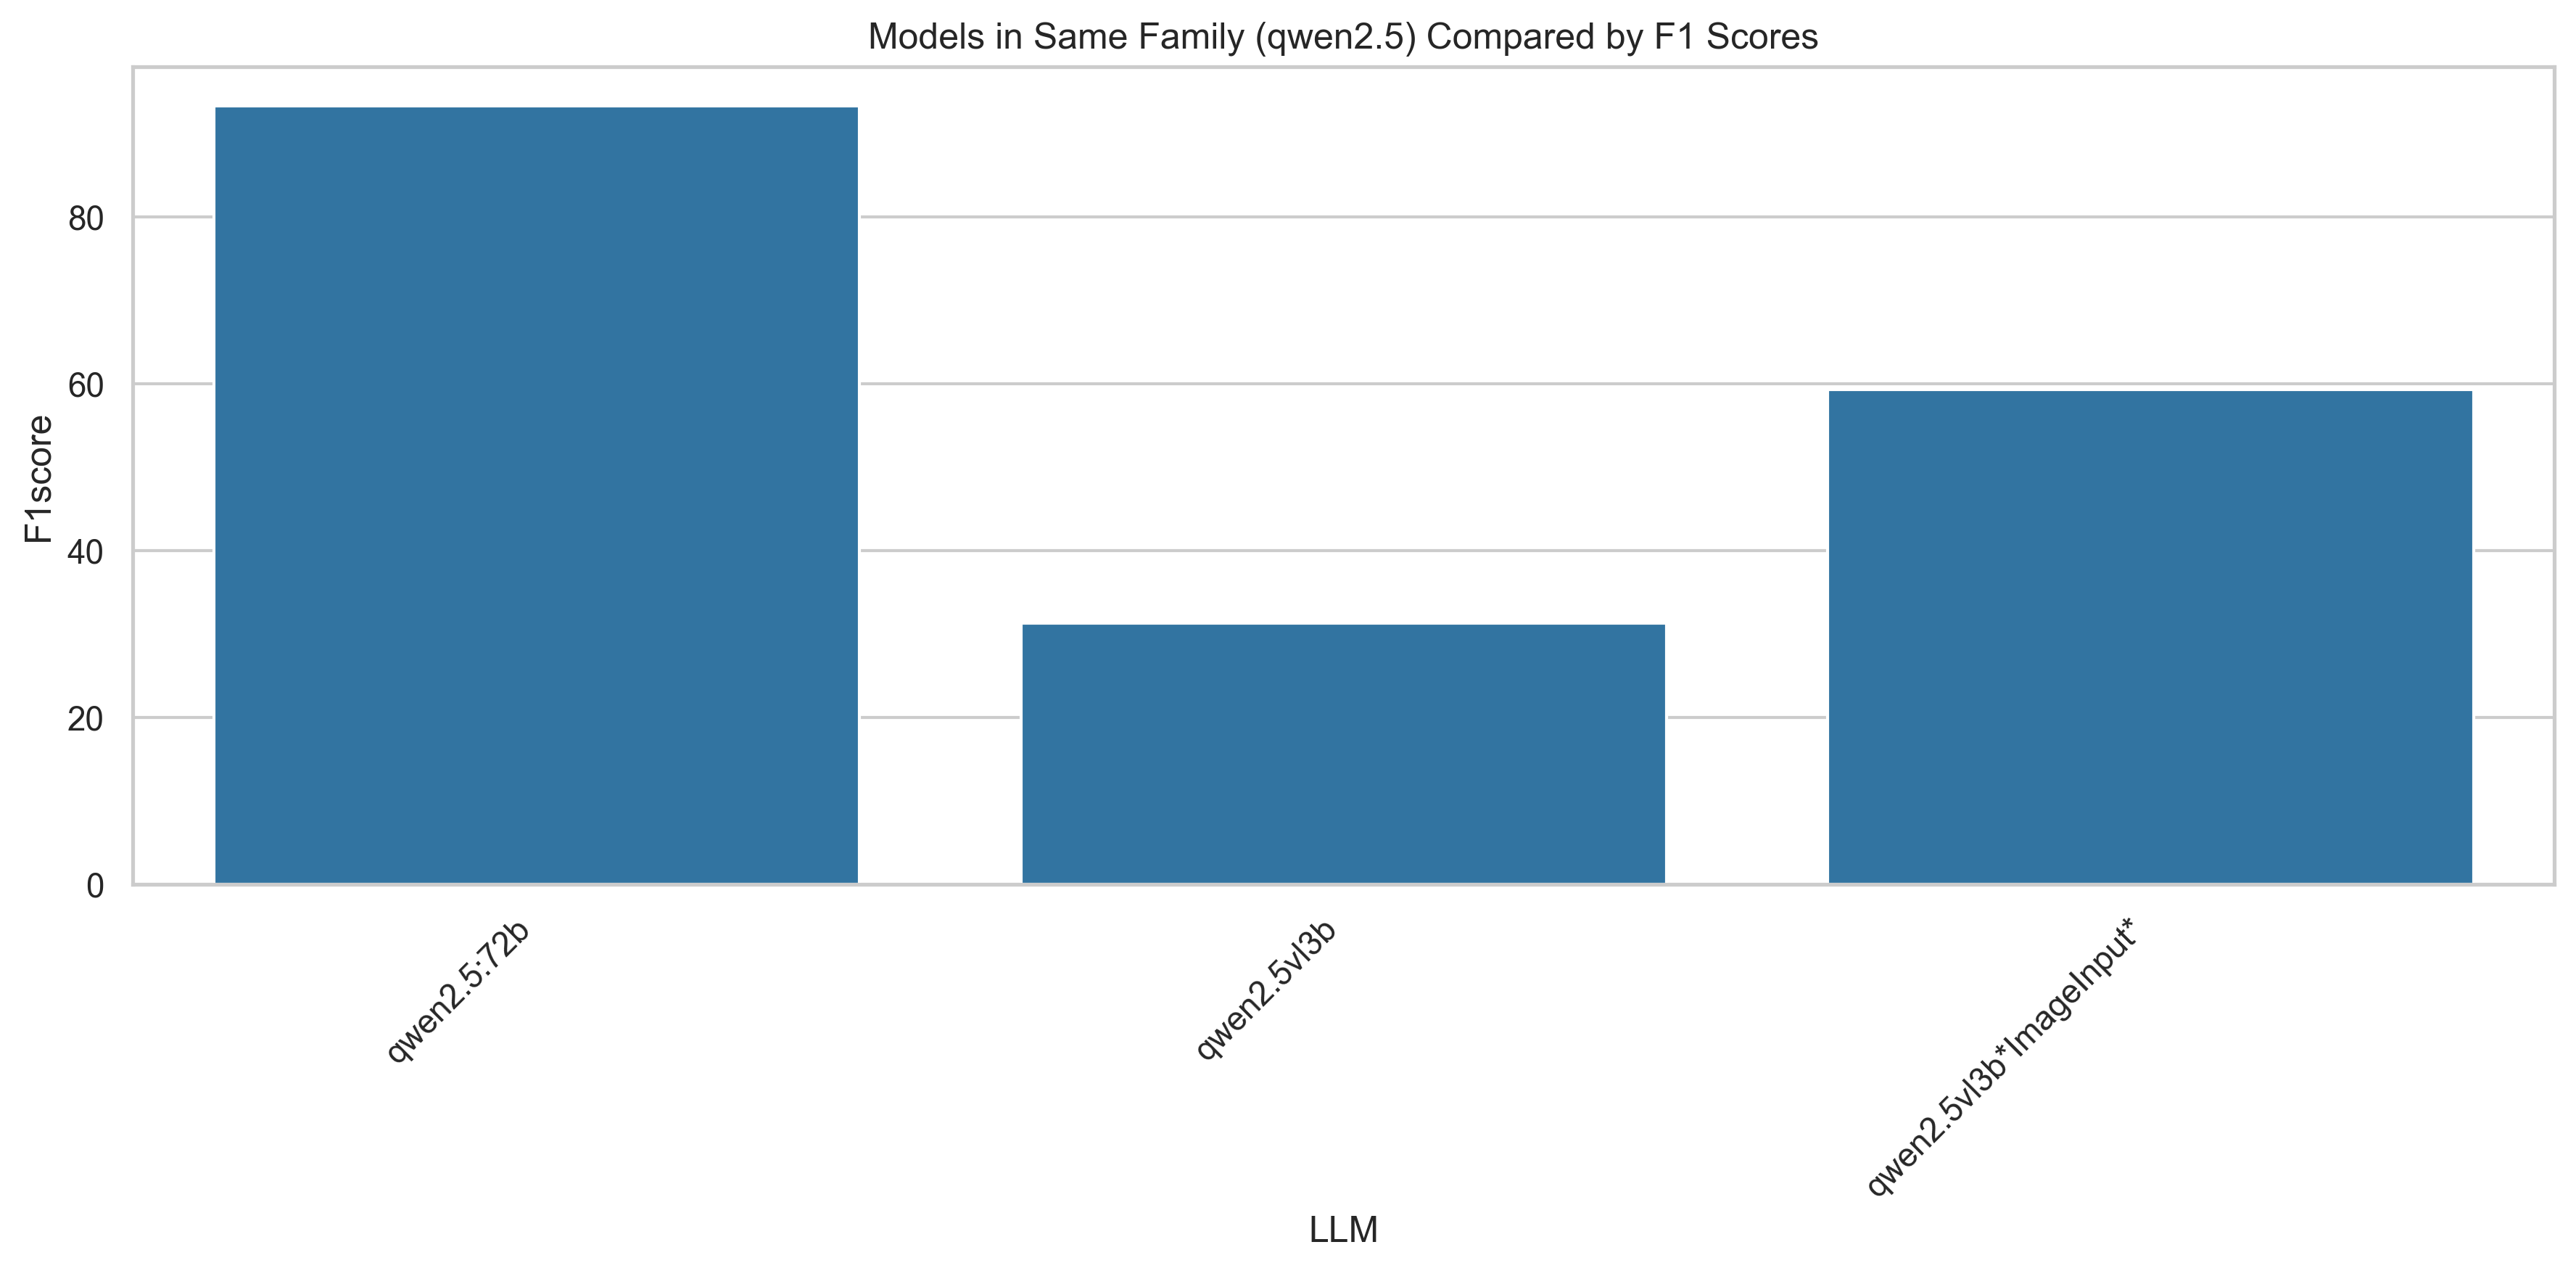

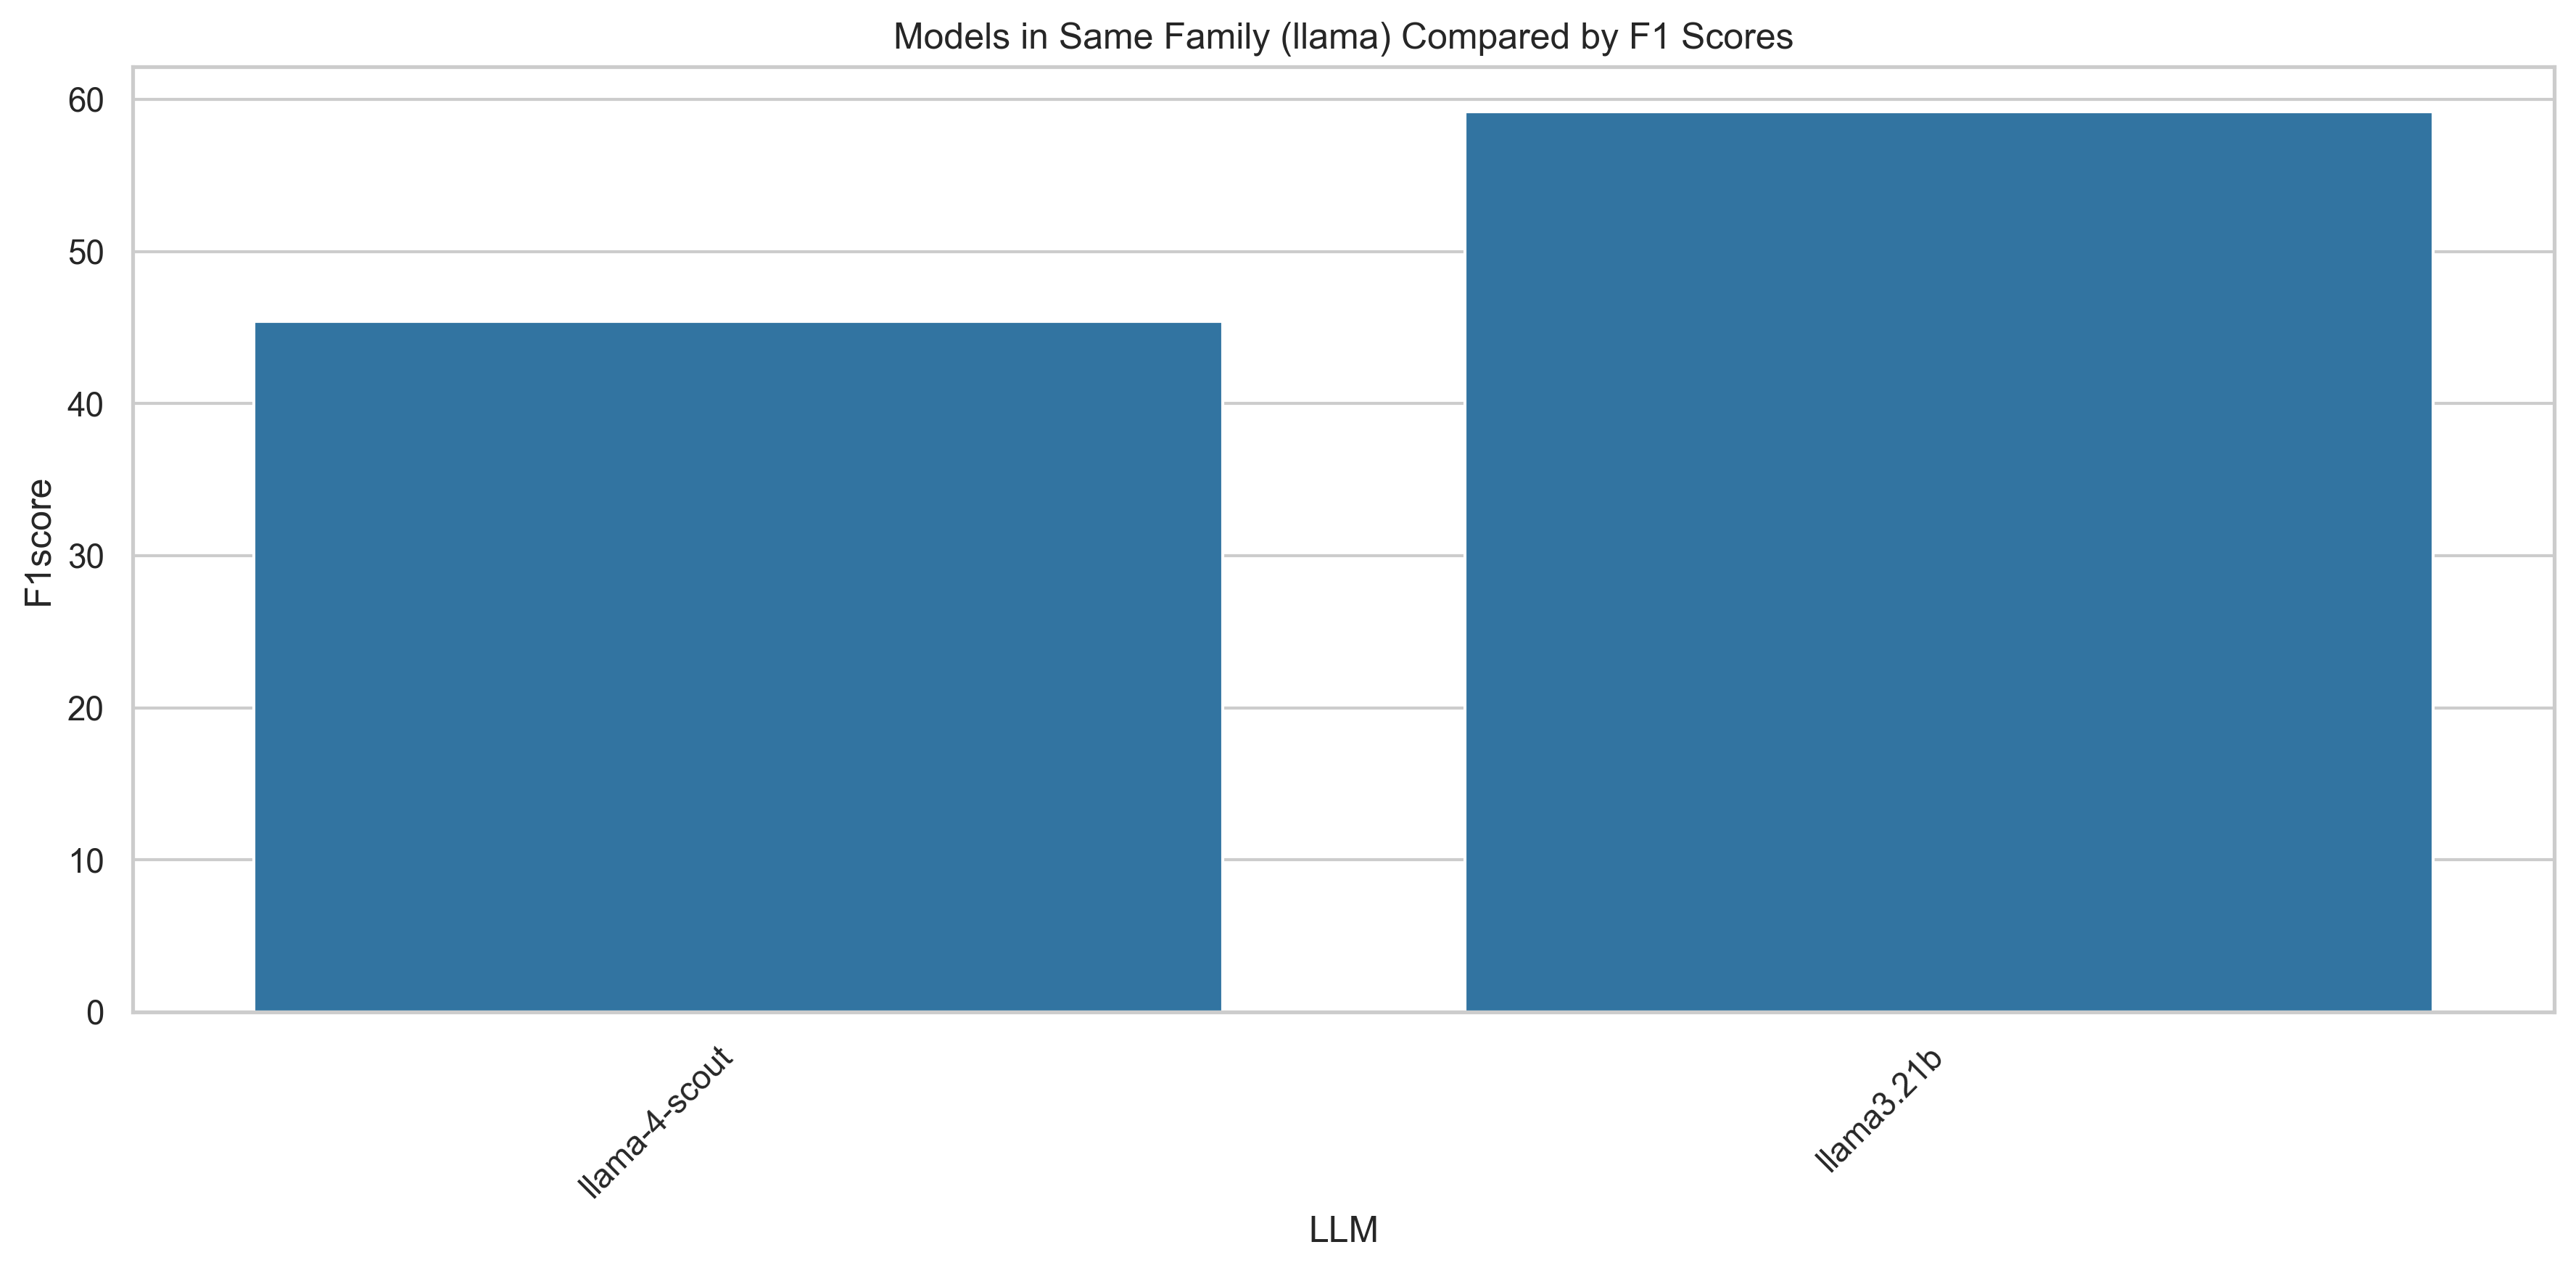

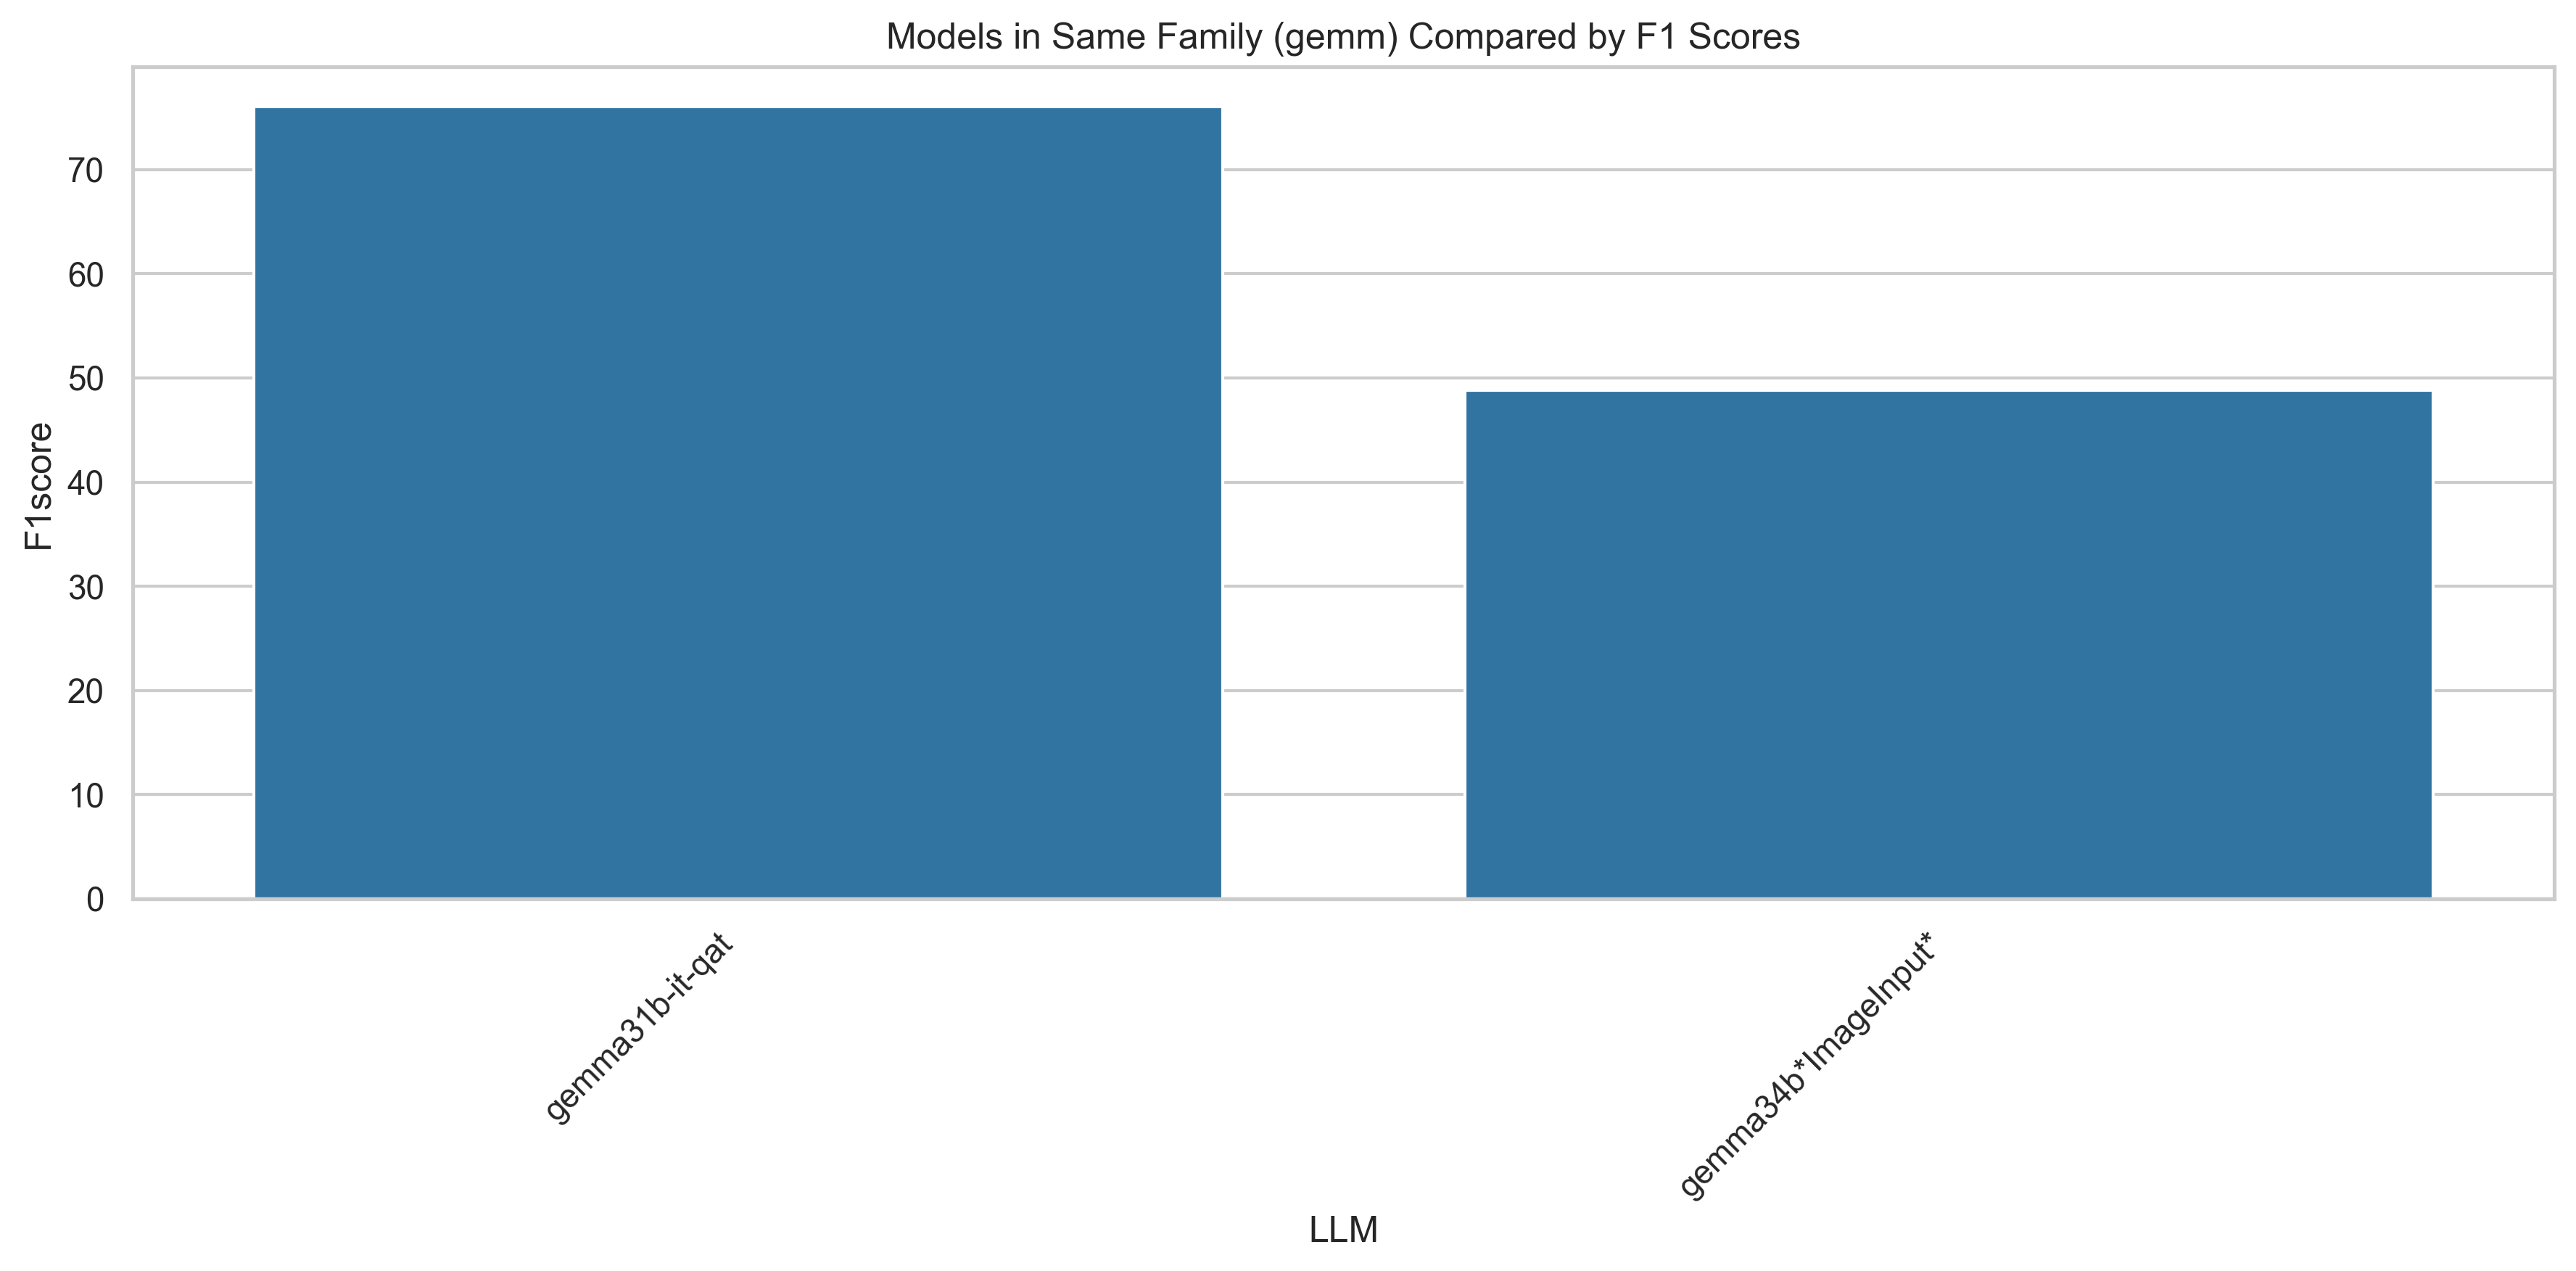

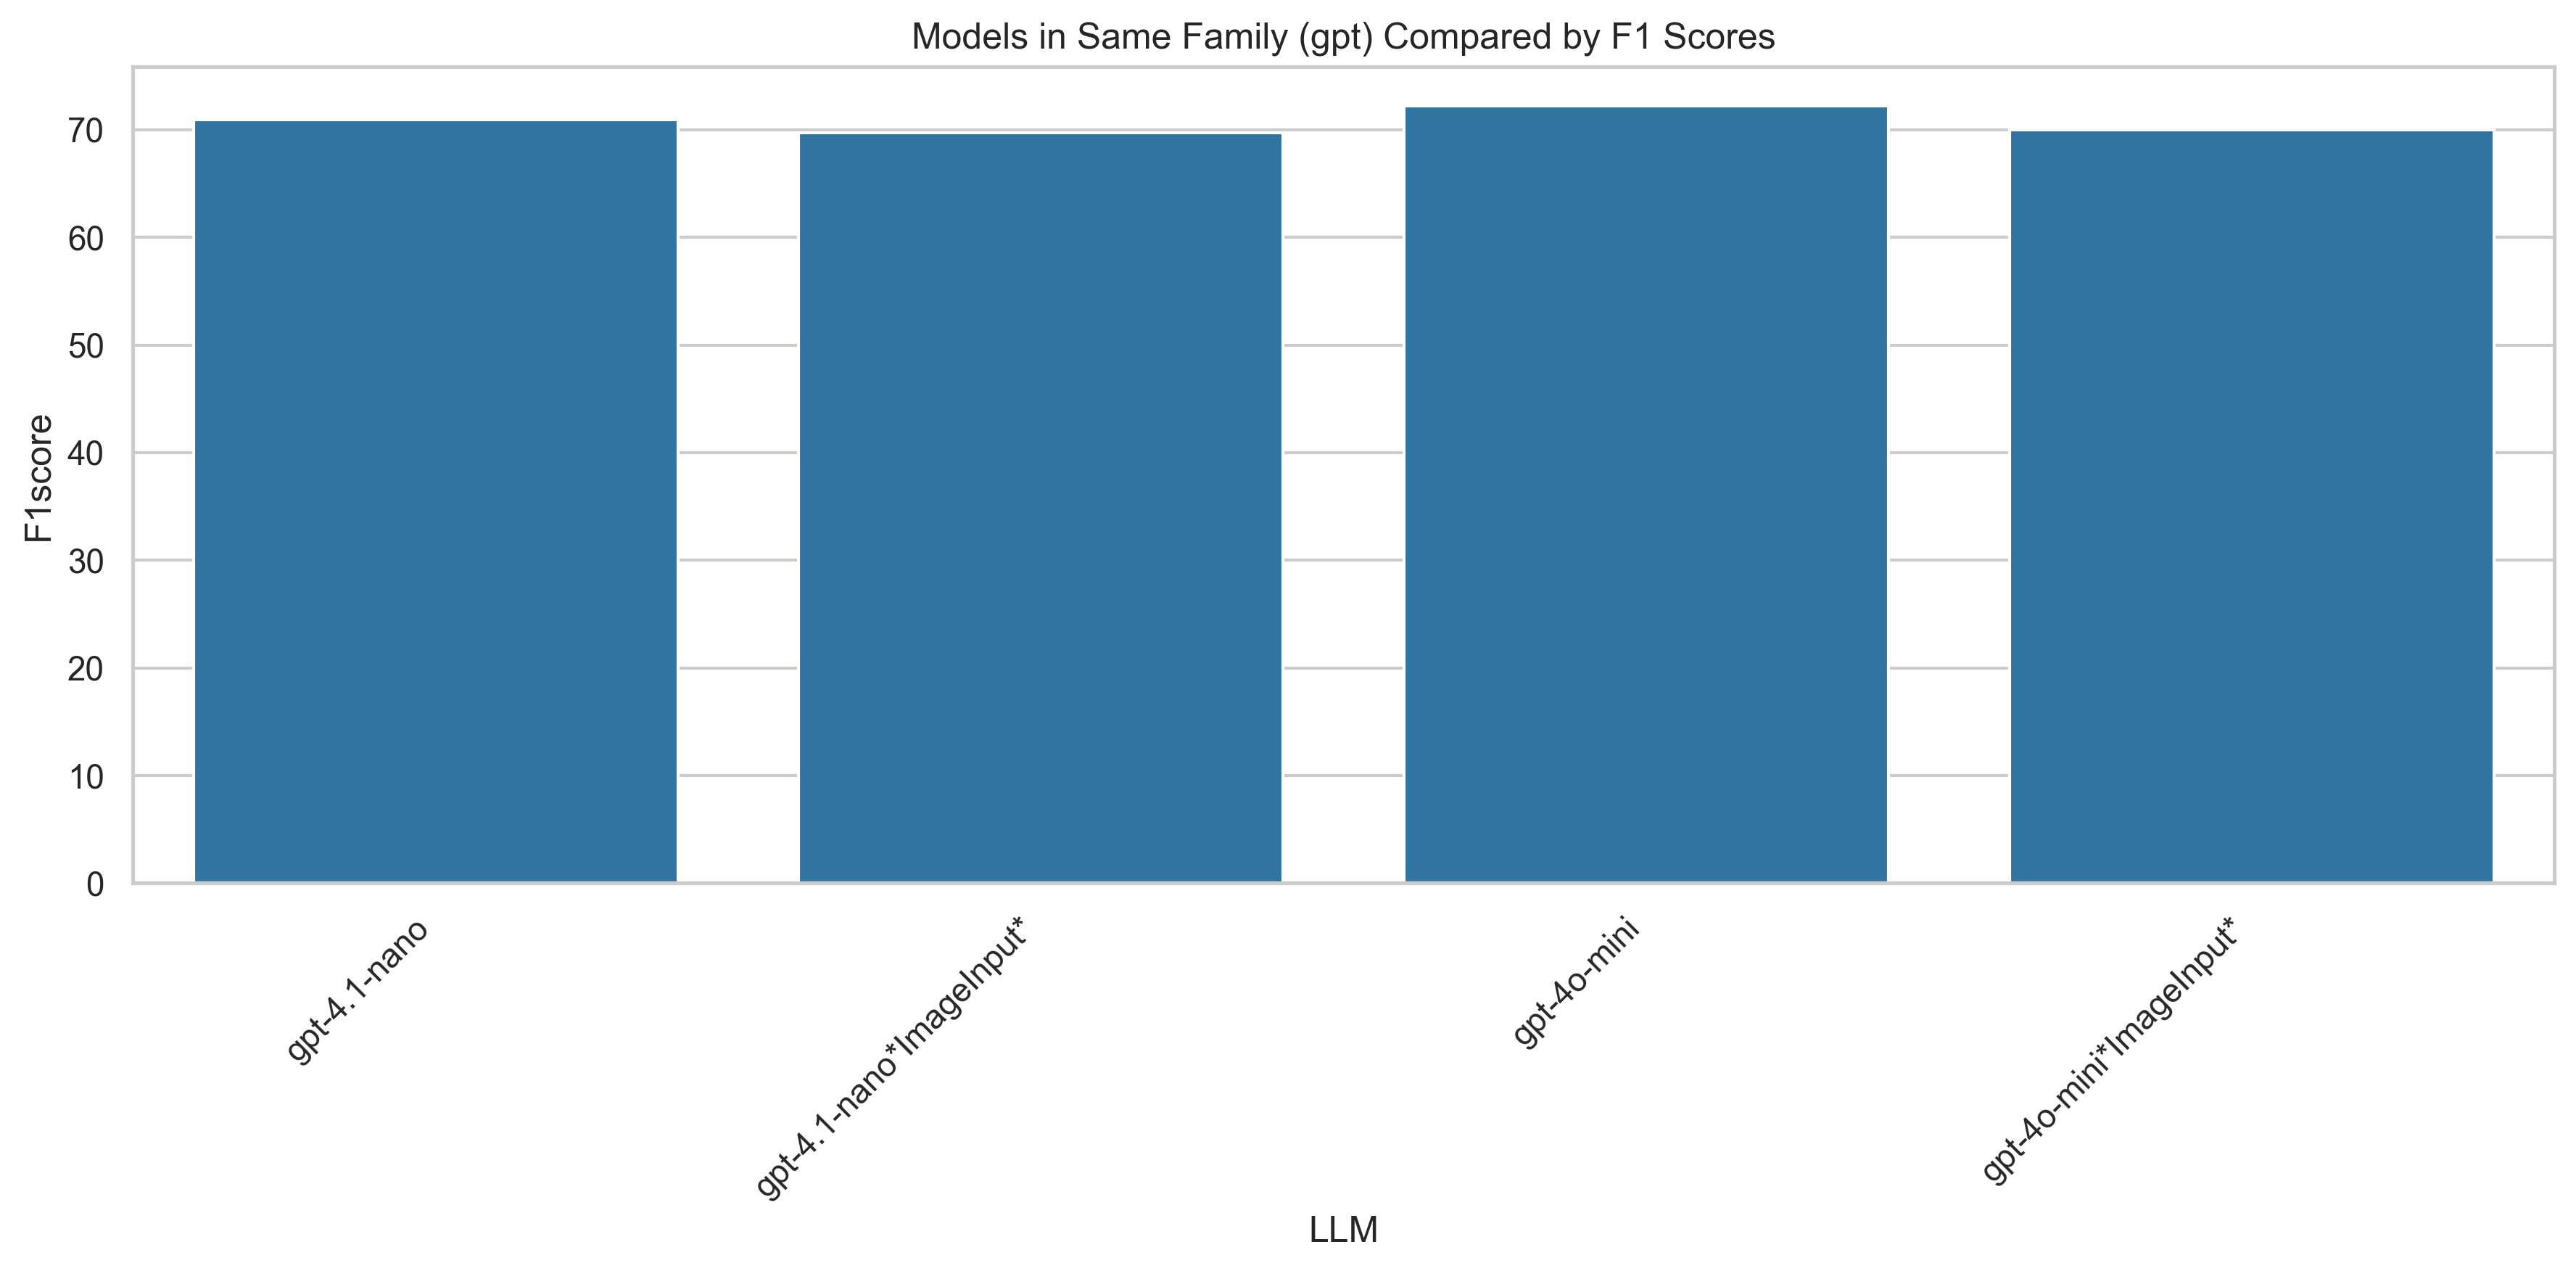

In [274]:
# Models in the same family compared by F1 Scores
familes = ["qwen2.5", "llama", "gemm", "gpt"]
for name in familes:
    family_models = combined[combined['LLM'].str.contains(name, case=False)].copy()
    if len(family_models) > 0:
        plt.figure(figsize=(12,6))
        sns.barplot(data=family_models, x='LLM', y='F1score')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Models in Same Family ({name}) Compared by F1 Scores')
        plt.tight_layout()
        plt.show()
    else:
        print(f'No {name} family models found')


In [275]:
# Load data properly for comprehensive analysis
h1 = pd.read_csv('fakeHospital1_results.csv')
h2 = pd.read_csv('fakeHospital2_results.csv')
h1['Hospital'] = 'Hospital1'
h2['Hospital'] = 'Hospital2'
all_data = pd.concat([h1, h2], ignore_index=True)
print(f"Total records: {len(all_data)}")
print(f"Hospital1 records: {len(h1)}")
print(f"Hospital2 records: {len(h2)}")

Total records: 28
Hospital1 records: 14
Hospital2 records: 14


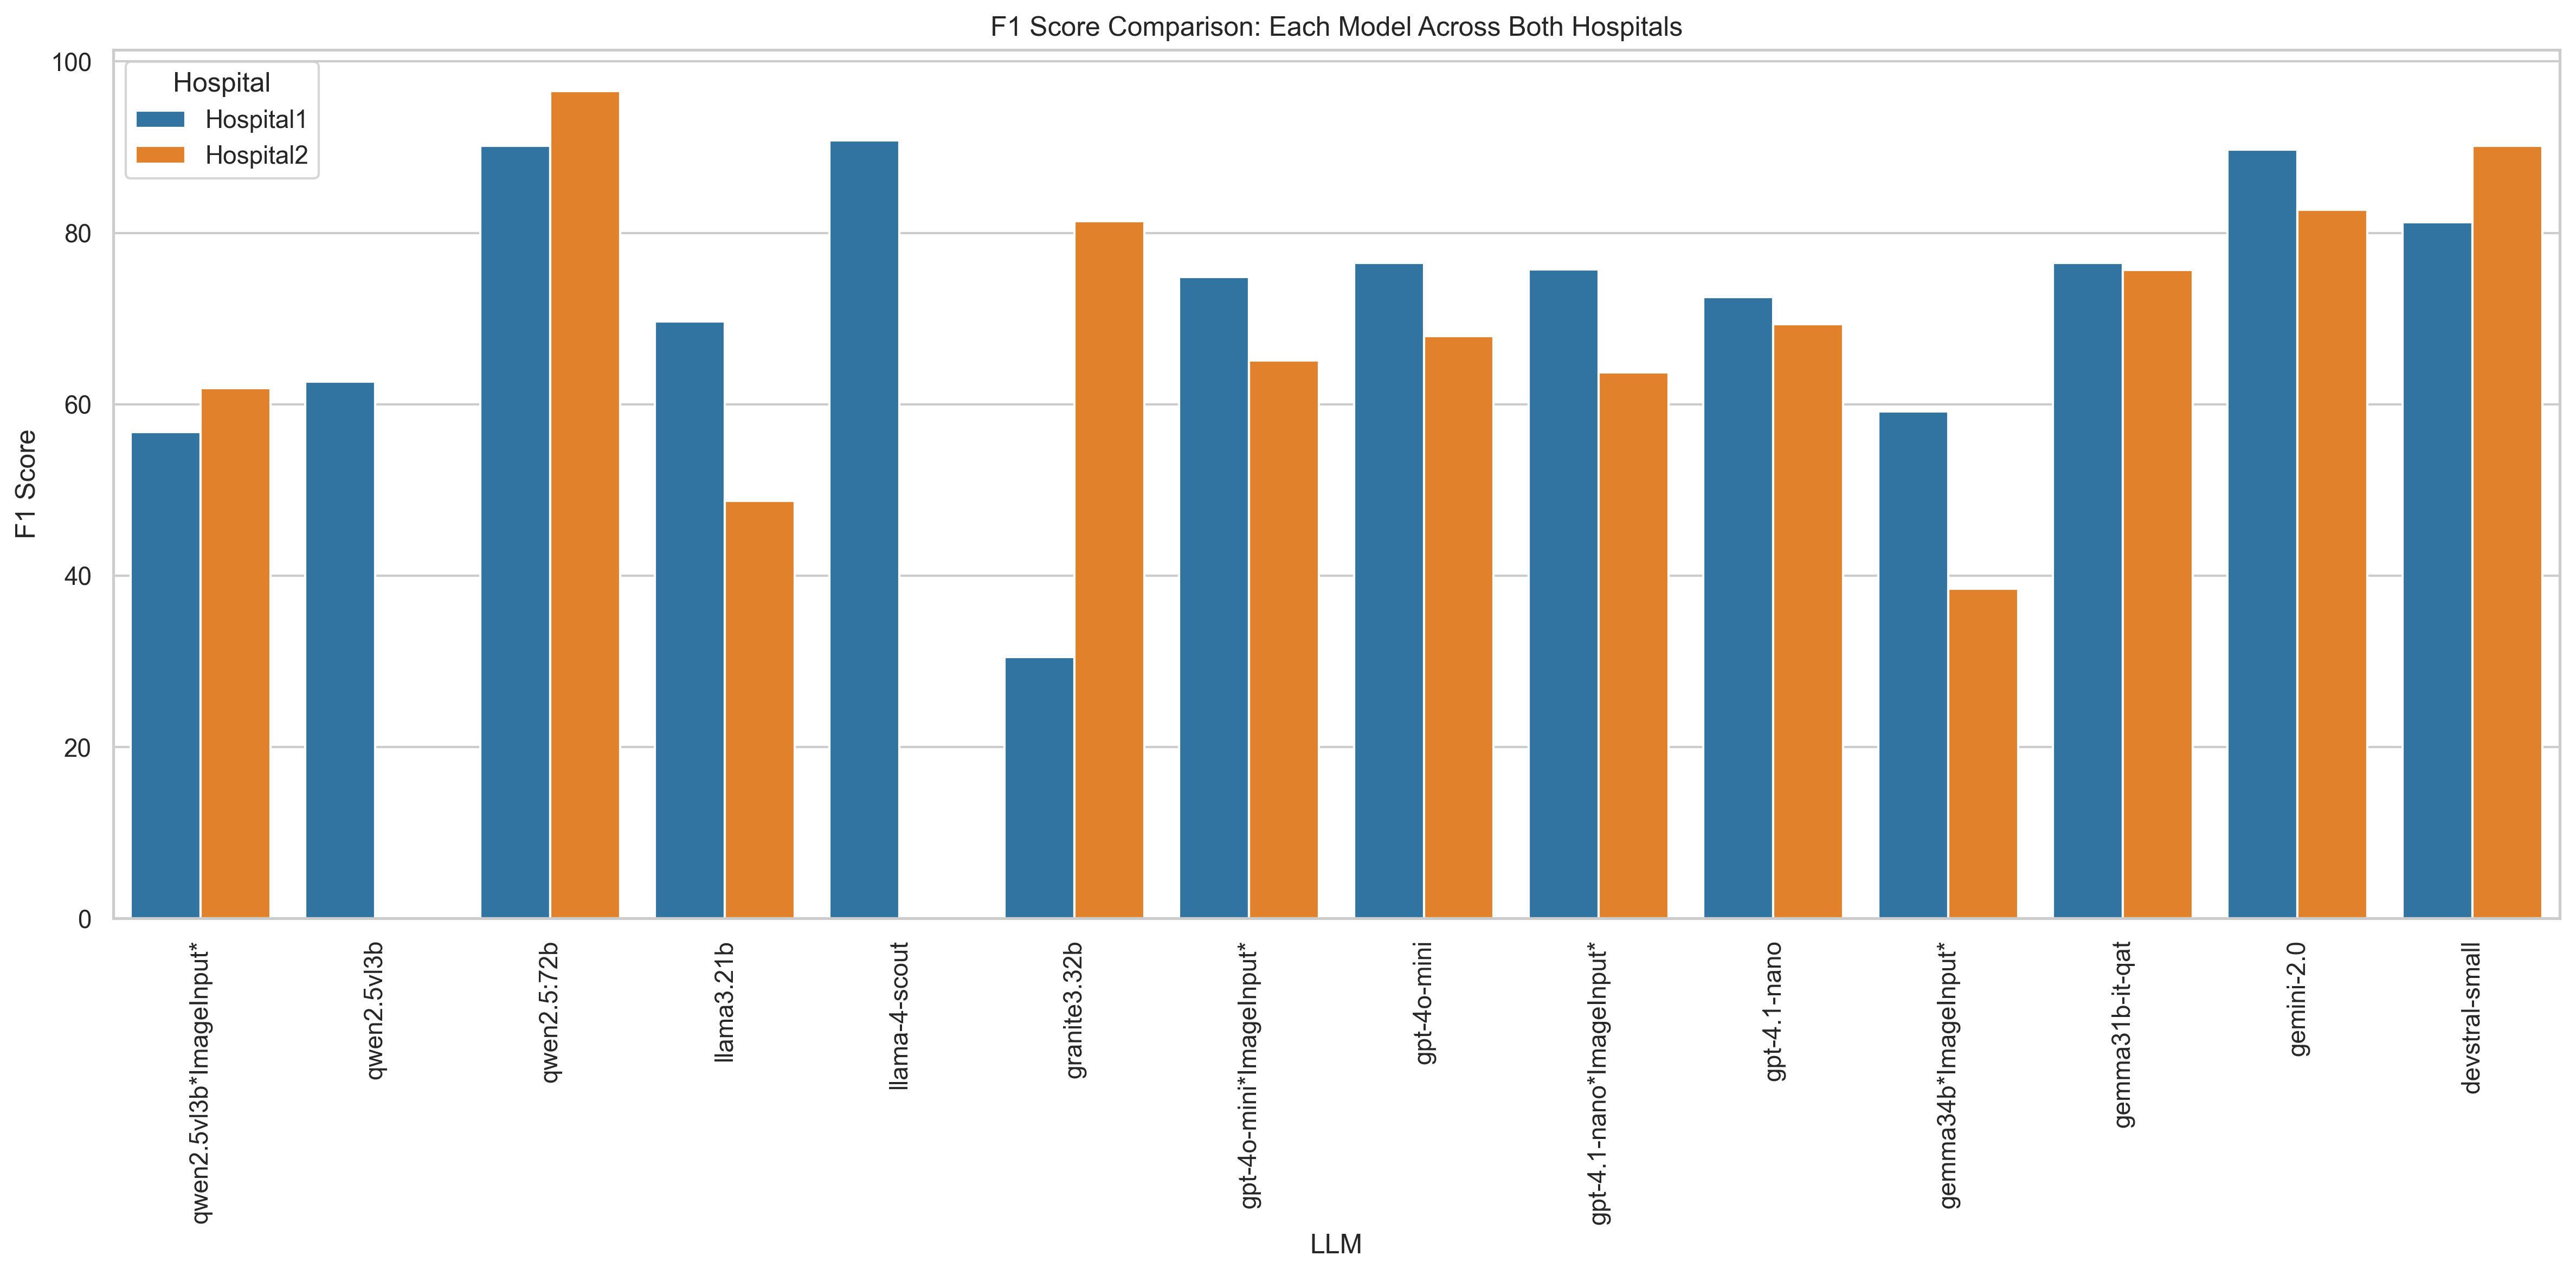

In [276]:
# 2. Model performance comparison across hospitals
plt.figure(figsize=(16, 8))
sns.barplot(data=all_data, x='LLM', y='F1score', hue='Hospital')
plt.xticks(rotation=90)
plt.title('F1 Score Comparison: Each Model Across Both Hospitals')
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()

Saved: 09_error_analysis_fp_fn


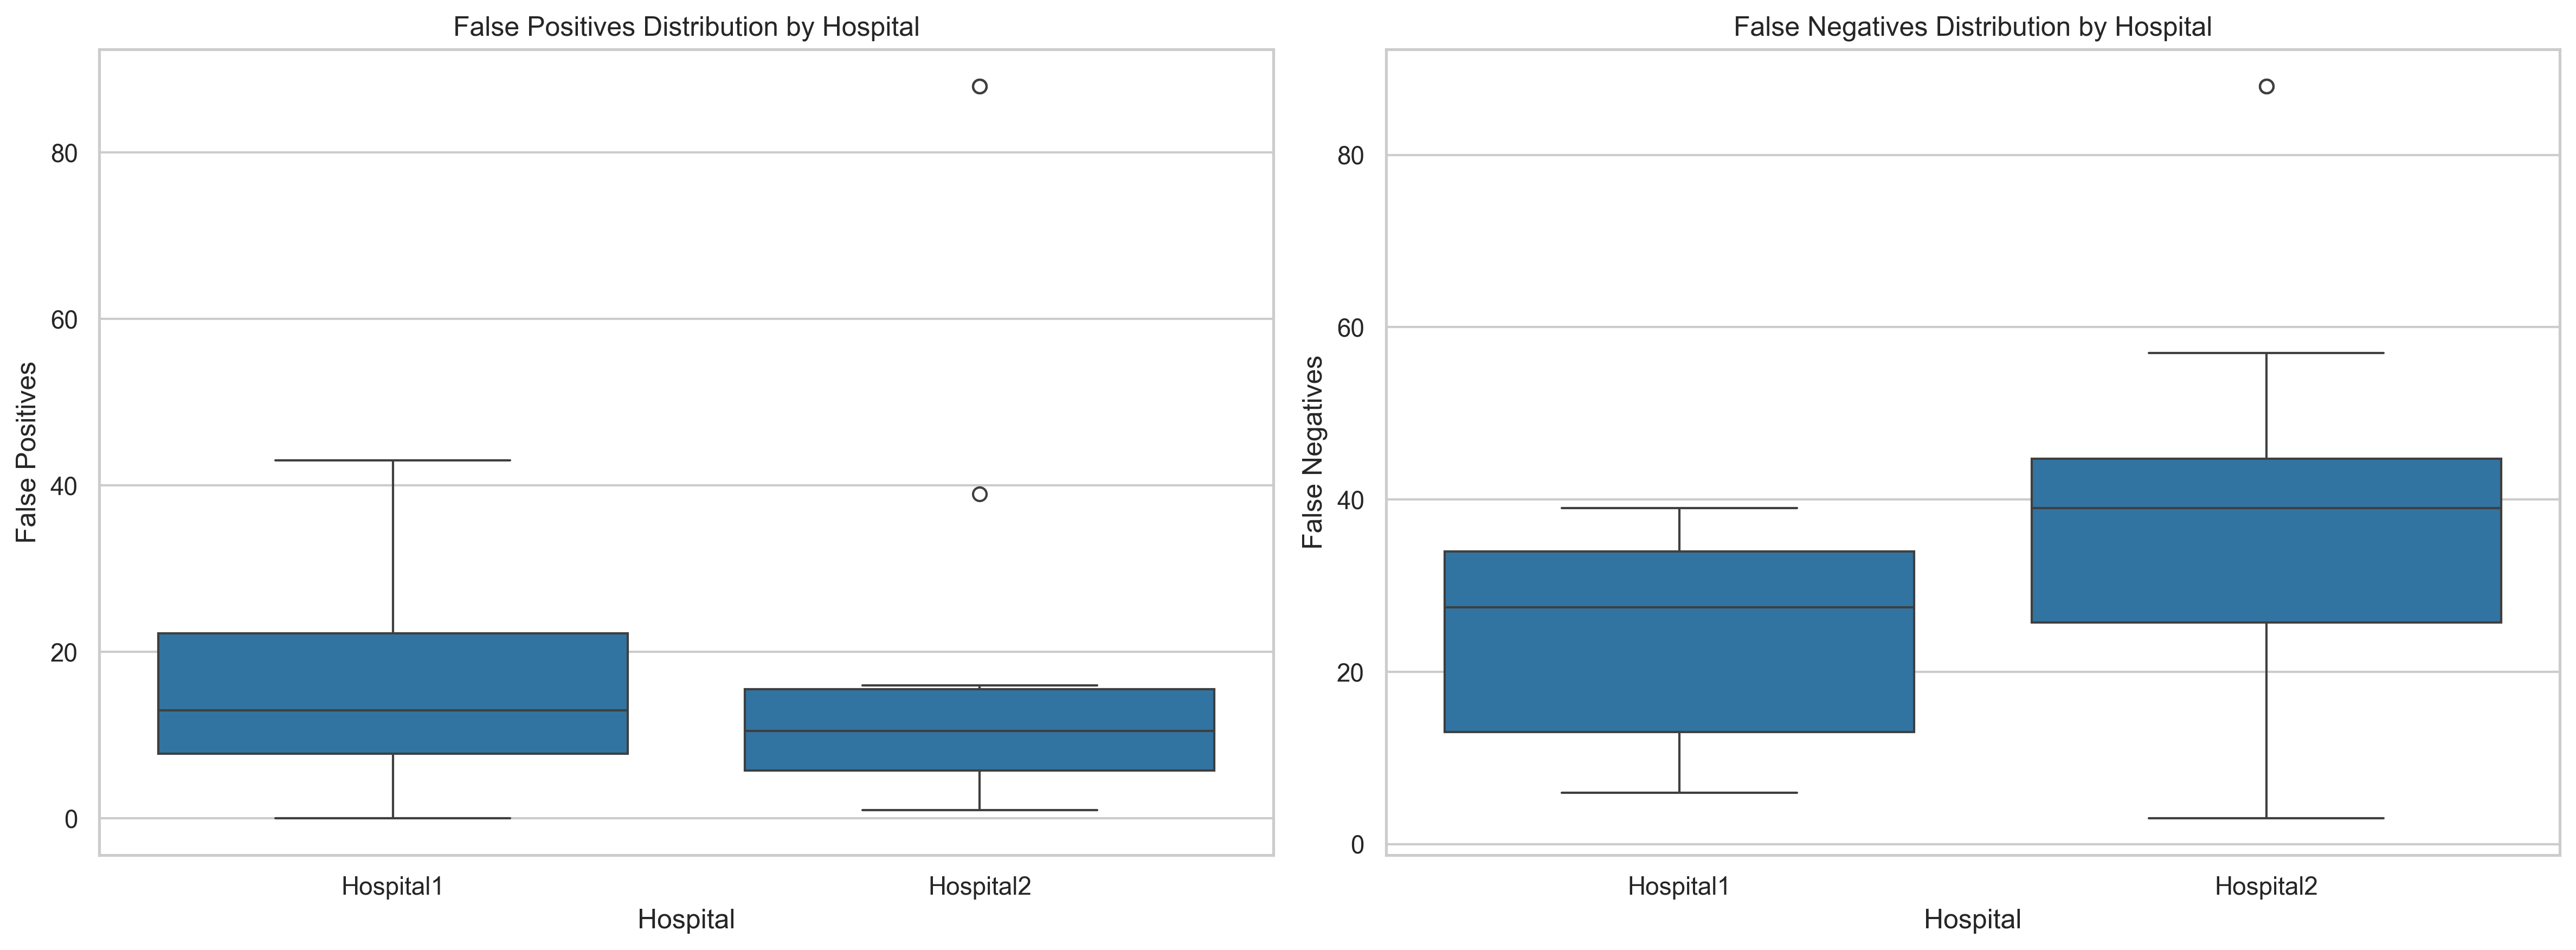

In [277]:
# Error analysis - False Positives vs False Negatives
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=all_individual, x='Hospital', y='False Positives', ax=axes[0])
axes[0].set_title('False Positives Distribution by Hospital')

sns.boxplot(data=all_individual, x='Hospital', y='False Negatives', ax=axes[1])
axes[1].set_title('False Negatives Distribution by Hospital')

plt.tight_layout()
save_plot('09_error_analysis_fp_fn')
plt.show()

Saved: 10_correlation_scatter_matrix


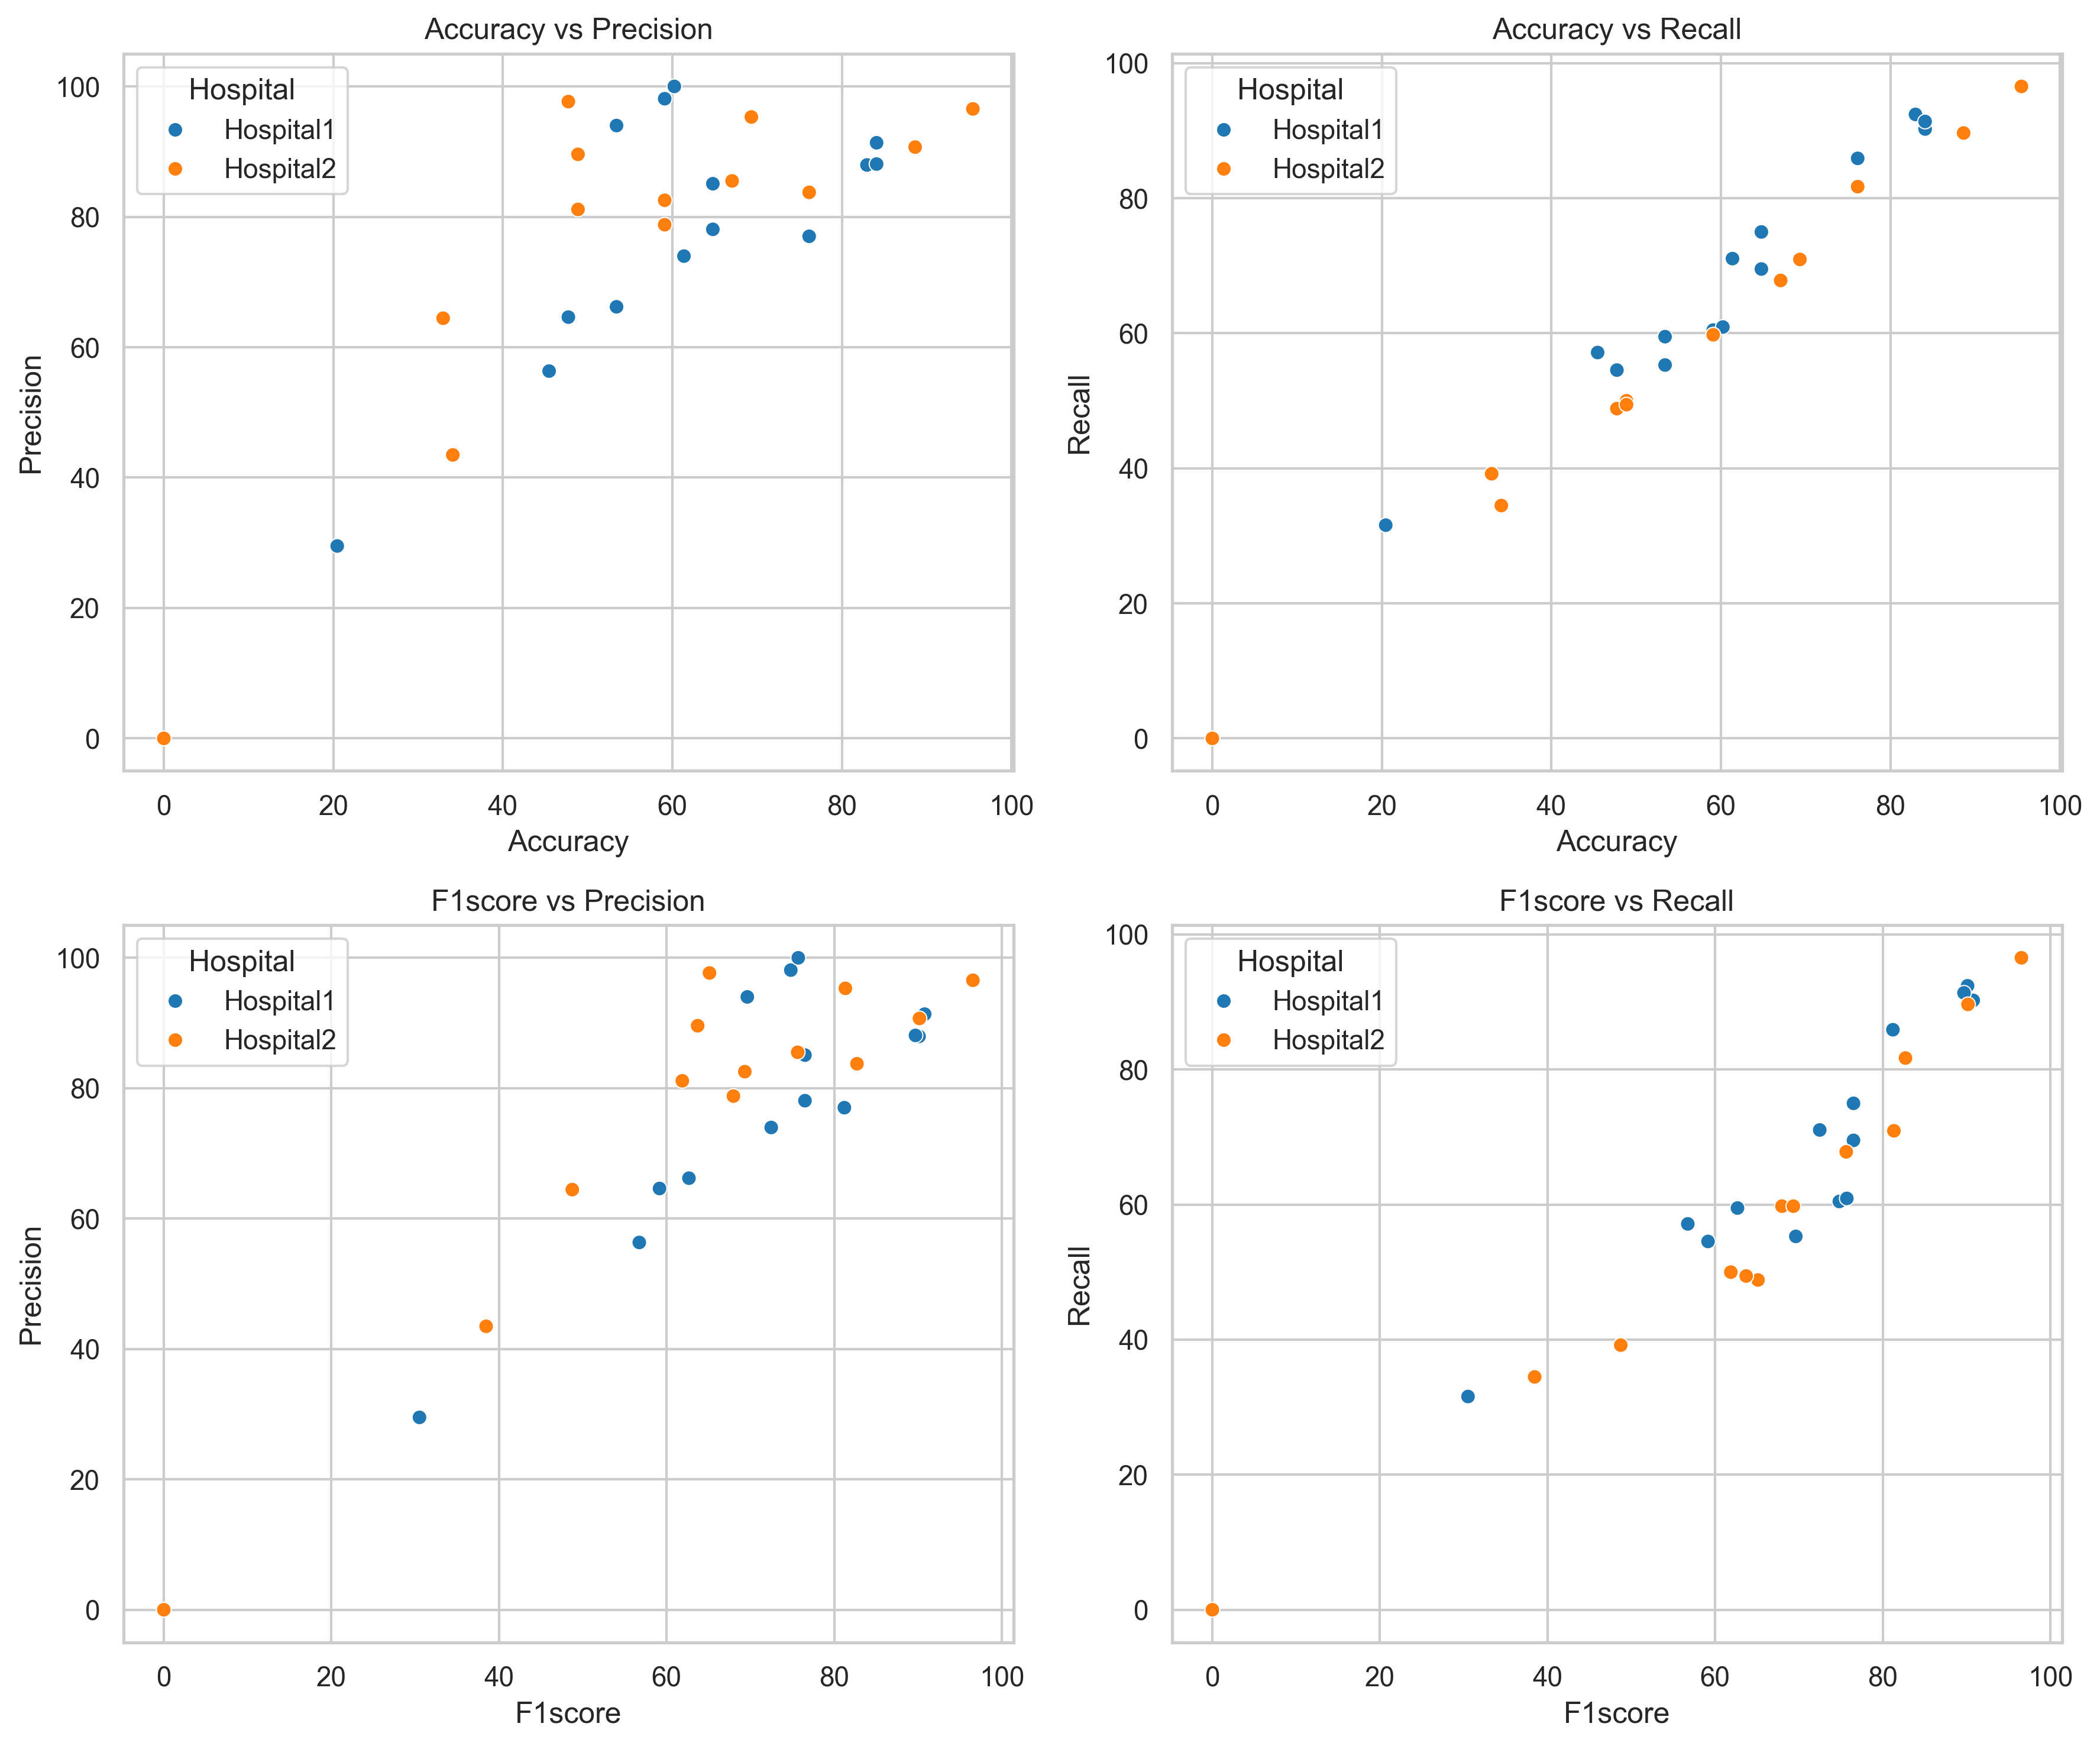

In [278]:
# Scatter plot matrix to show correlations
metrics = ['Accuracy', 'F1score', 'Precision', 'Recall']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, metric1 in enumerate(metrics[:2]):
    for j, metric2 in enumerate(metrics[2:]):
        sns.scatterplot(data=all_data, x=metric1, y=metric2, hue='Hospital', ax=axes[i,j])
        axes[i,j].set_title(f'{metric1} vs {metric2}')

plt.tight_layout()
save_plot('10_correlation_scatter_matrix')
plt.show()

Saved: 11_model_source_comparison


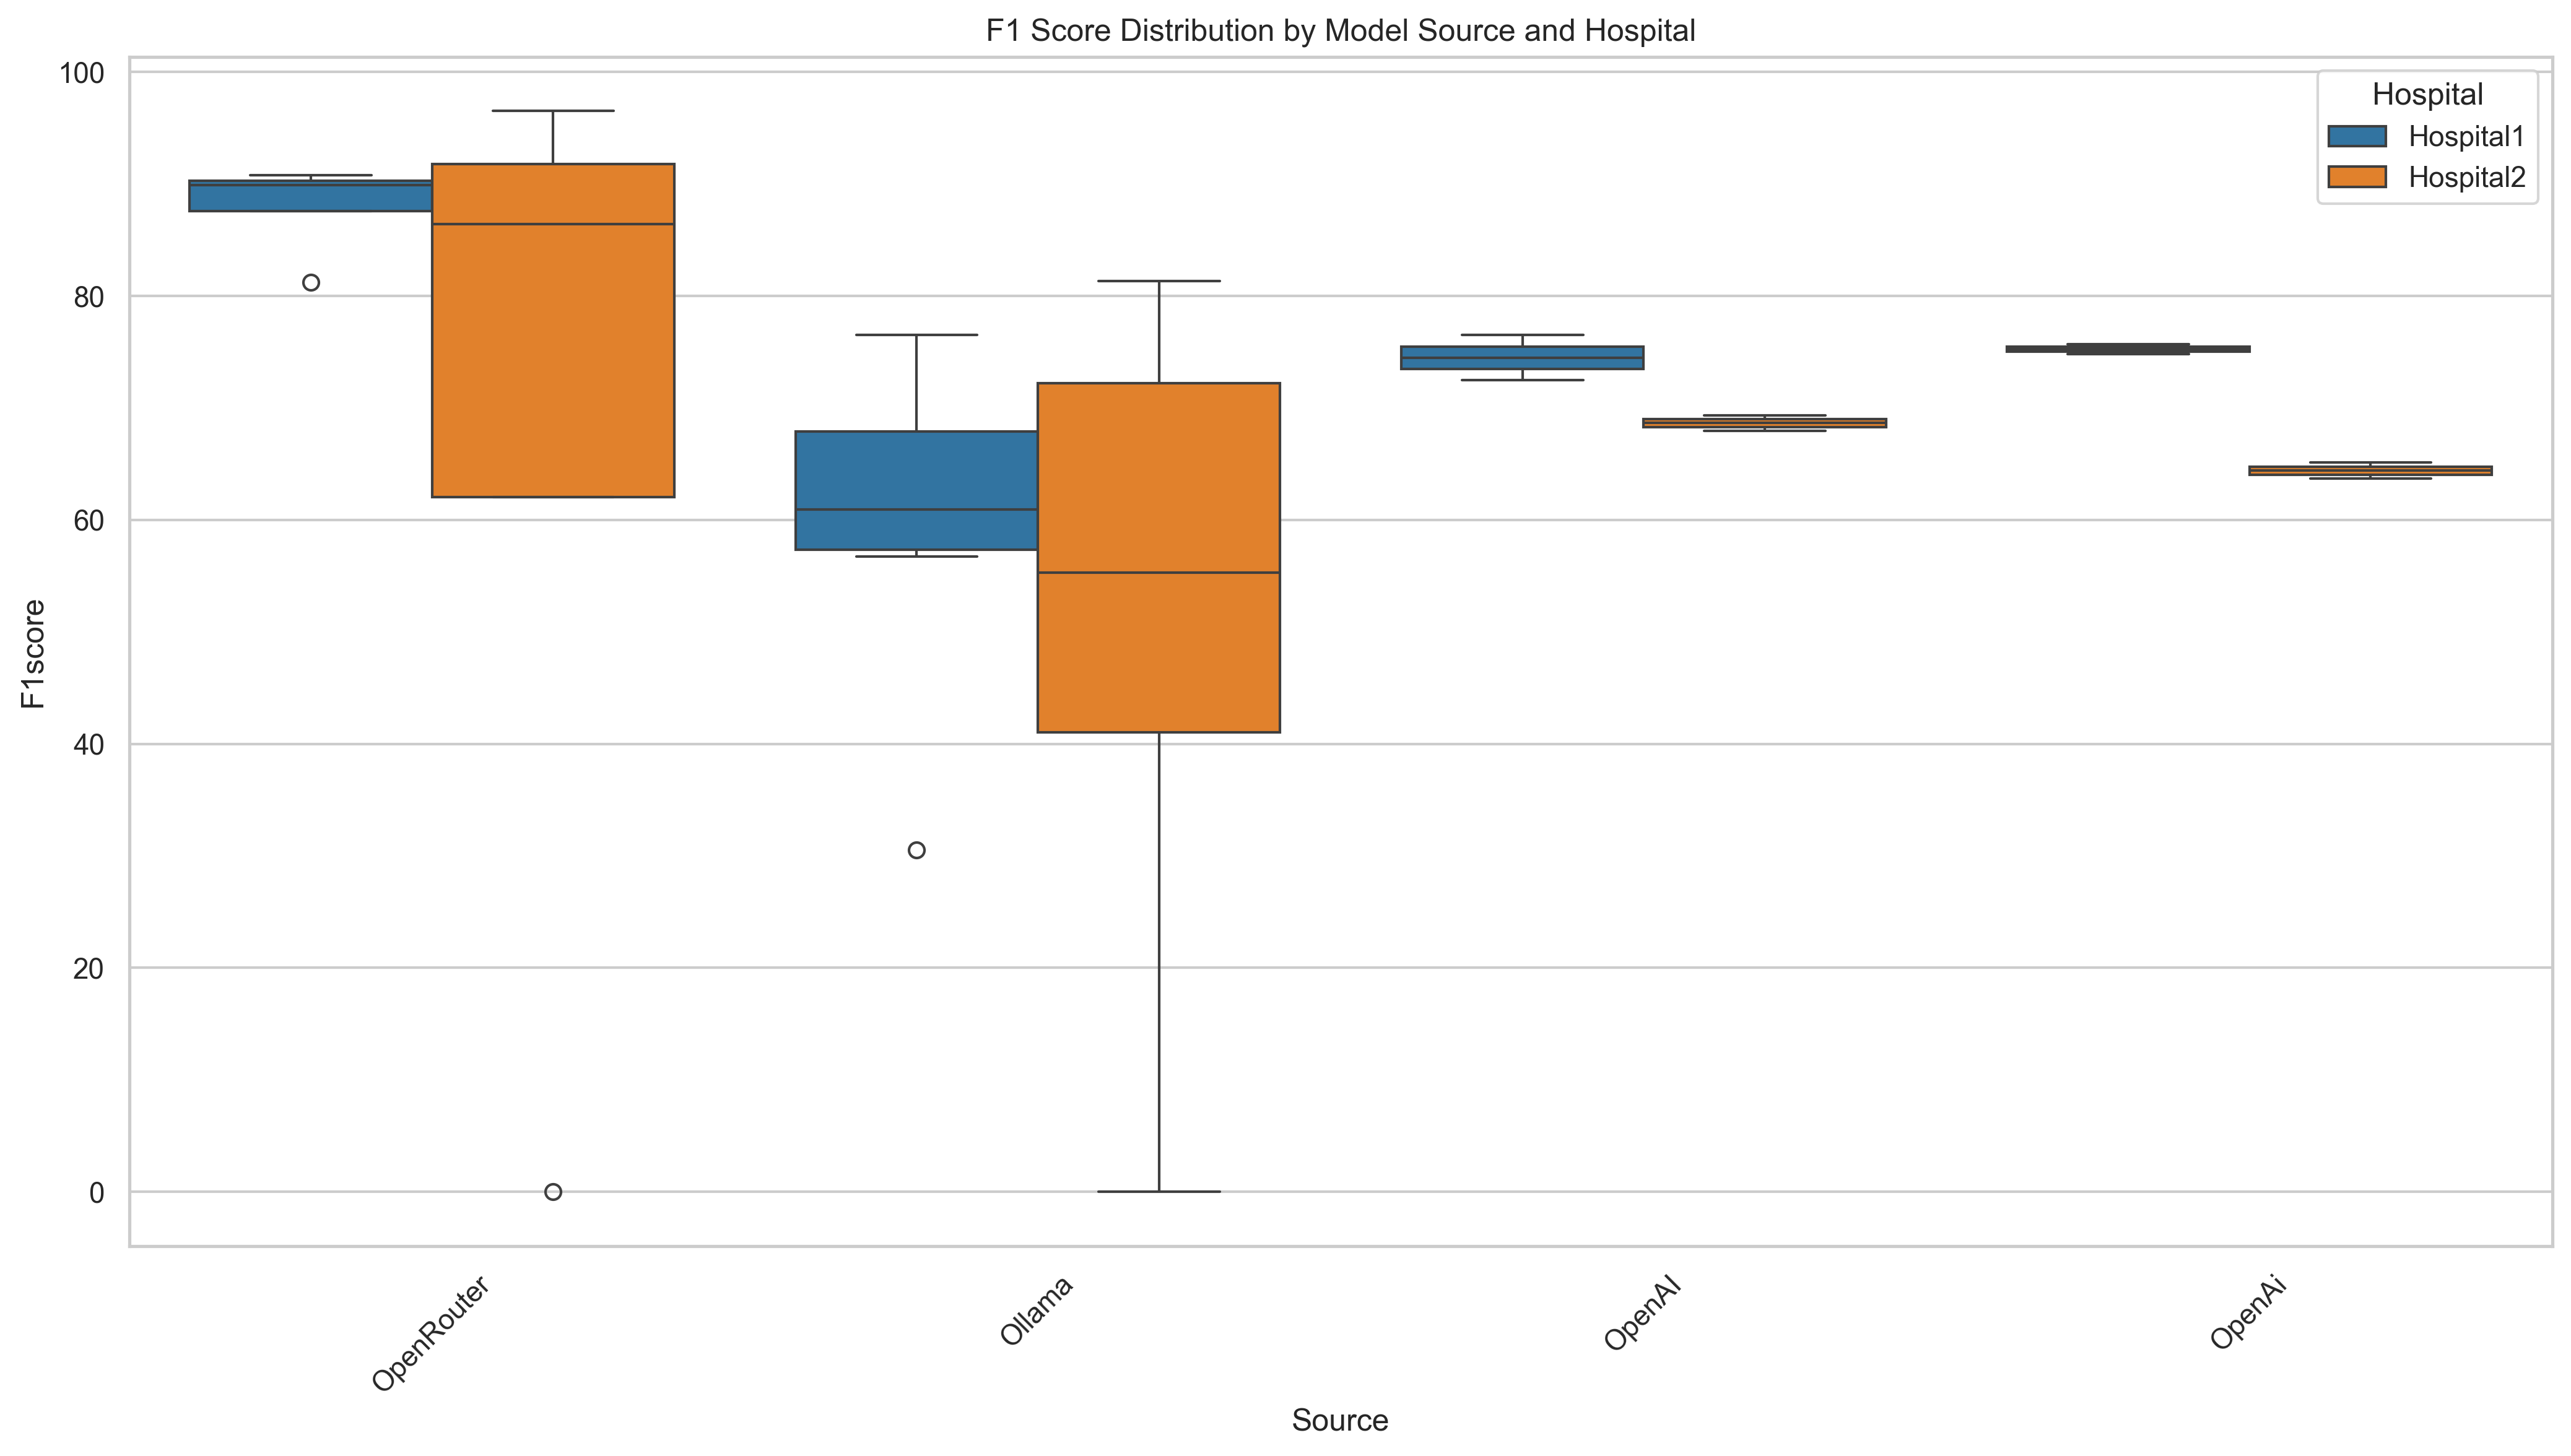

In [279]:
# Model source comparison
plt.figure(figsize=(14, 8))
sns.boxplot(data=all_individual, x='Source', y='F1score', hue='Hospital')
plt.title('F1 Score Distribution by Model Source and Hospital')
plt.xticks(rotation=45)
plt.tight_layout()
save_plot('11_model_source_comparison')
plt.show()

Saved: 12_performance_heatmap


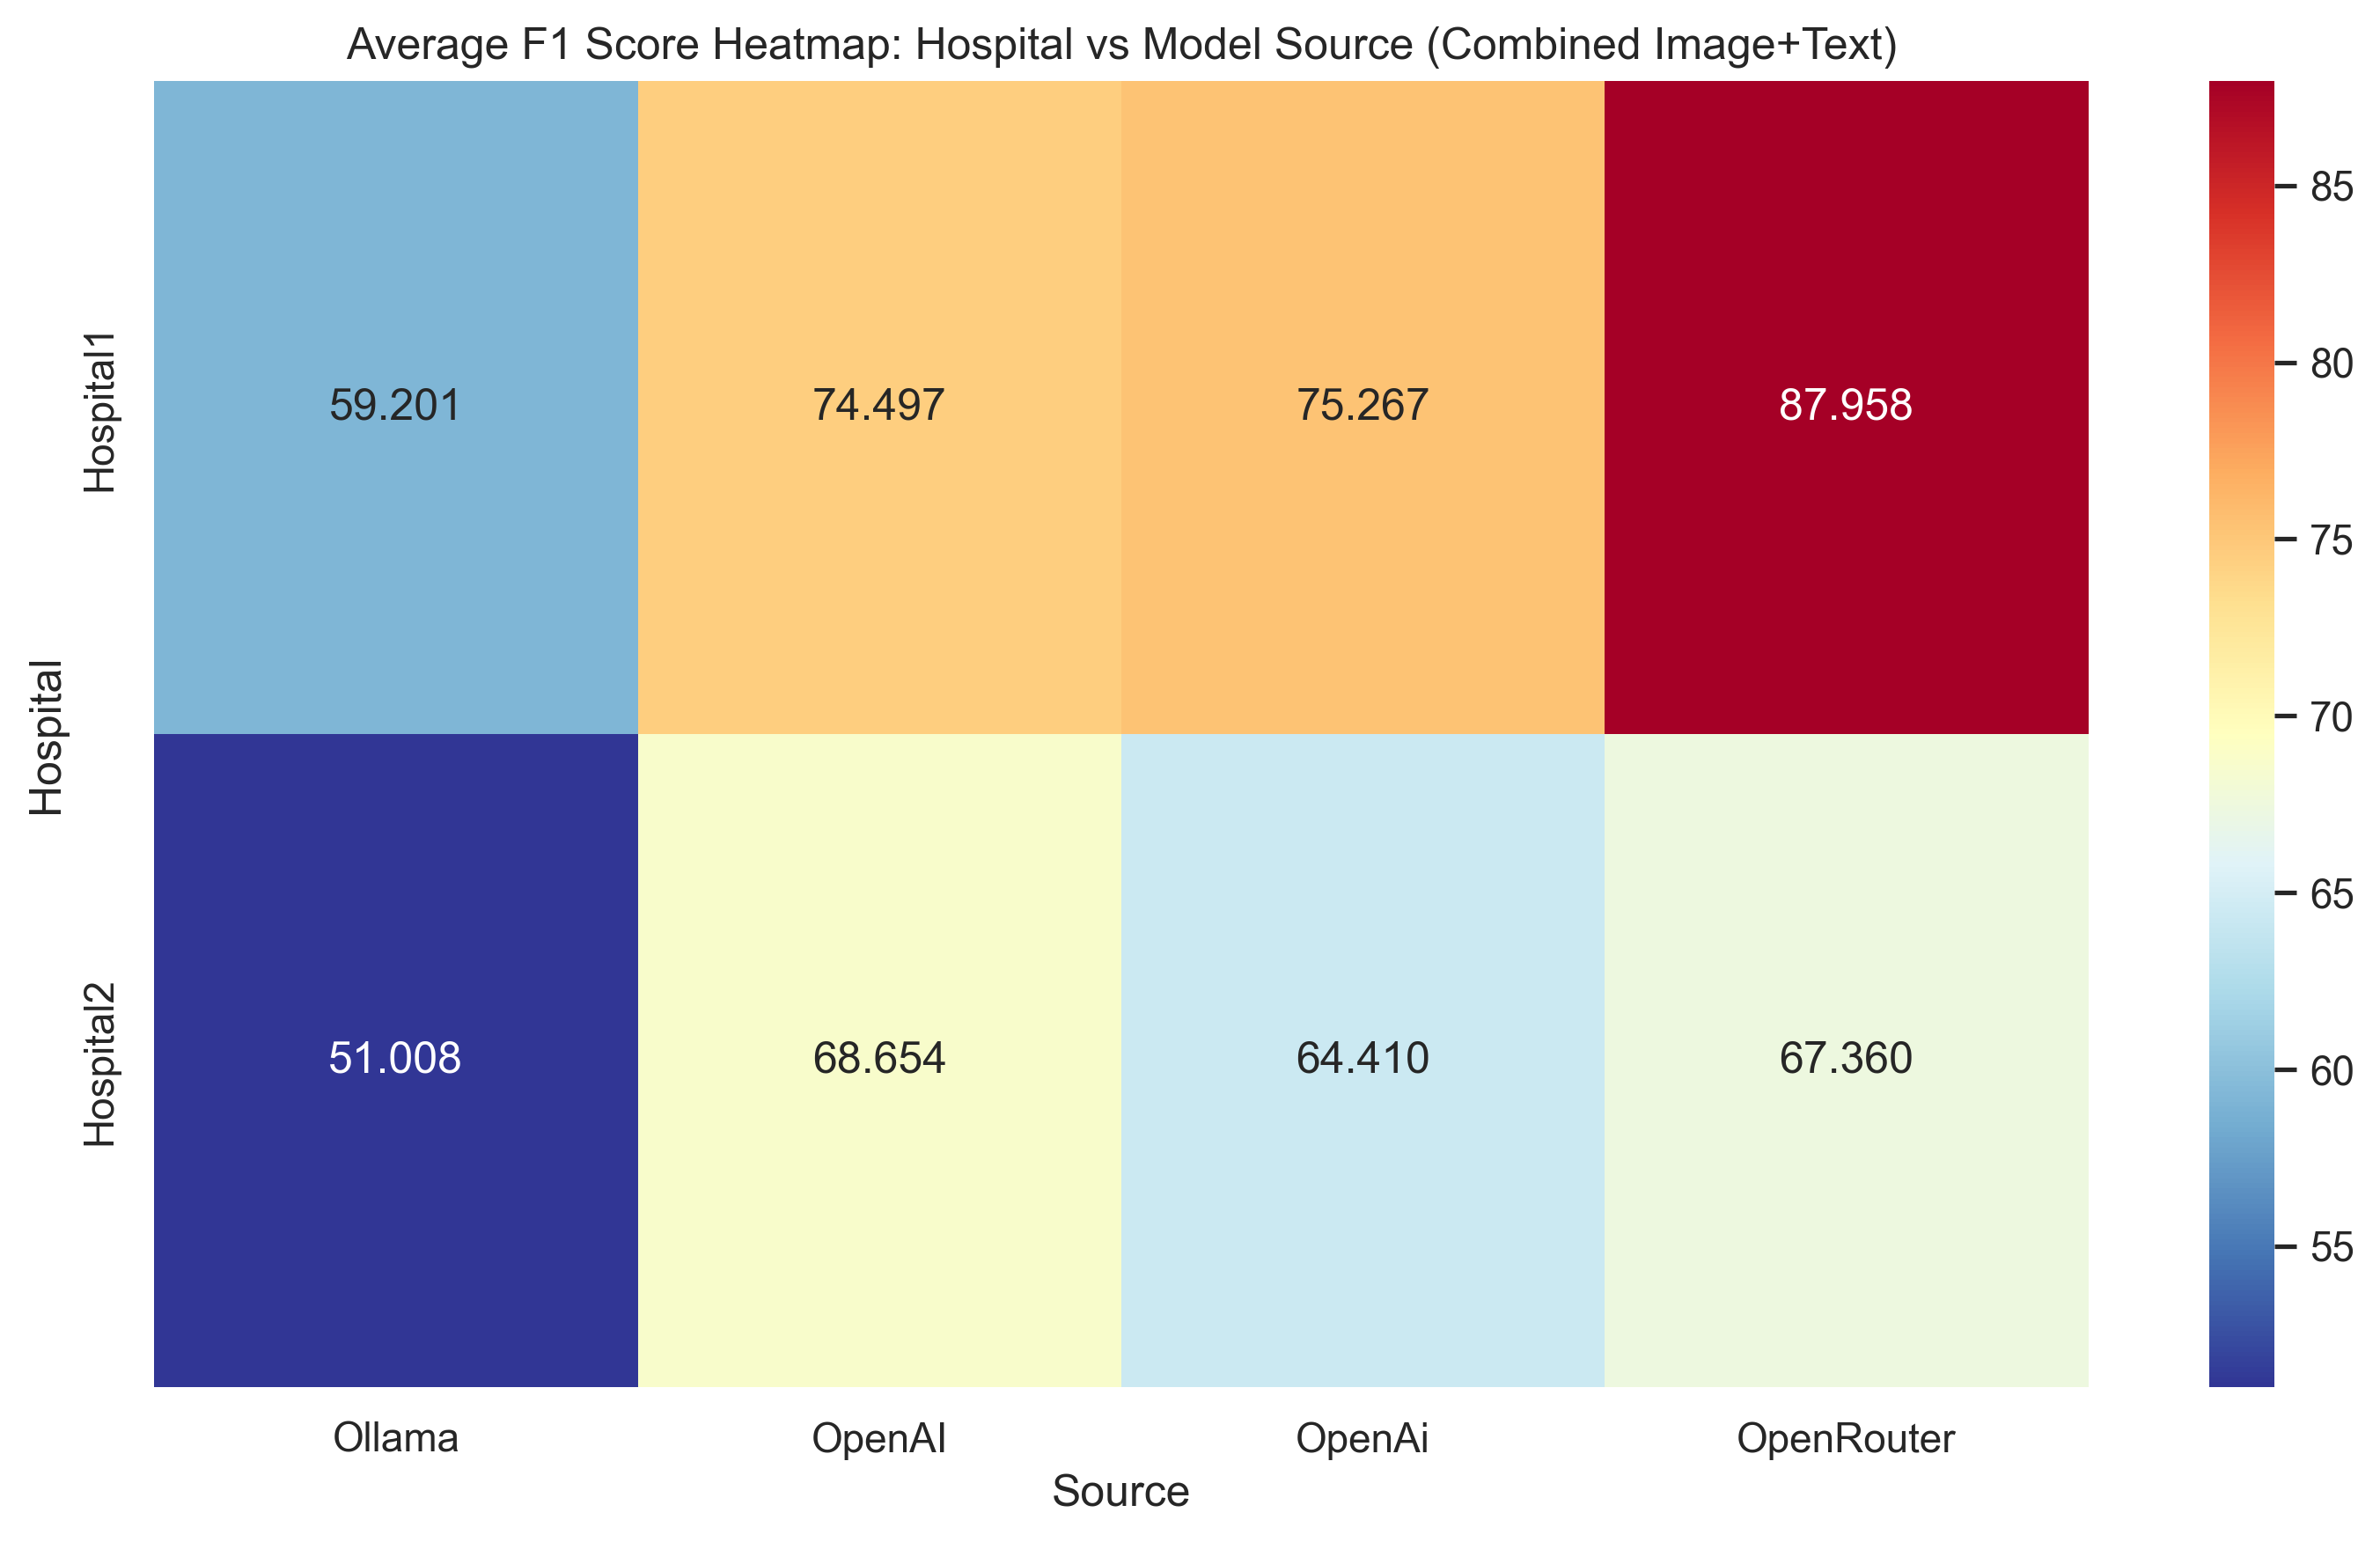

In [280]:
# Heatmap of average performance metrics
pivot_data = all_individual.groupby(['Hospital', 'Source'])[['Accuracy', 'F1score', 'Precision', 'Recall']].mean().reset_index()
pivot_table = pivot_data.pivot(index='Hospital', columns='Source', values='F1score')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='RdYlBu_r', fmt='.3f')
plt.title('Average F1 Score Heatmap: Hospital vs Model Source (Combined Image+Text)')
plt.tight_layout()
save_plot('12_performance_heatmap')
plt.show()

In [ ]:
# Create a single PDF with all graphs
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create PDF filename with timestamp
pdf_filename = f'all_visualizations_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pdf'
pdf_path = os.path.join(output_dir, pdf_filename)

print(f"Creating combined PDF: {pdf_filename}")
print("This will recreate all graphs and save them to a single PDF...")

with PdfPages(pdf_path) as pdf:
    # 1. Accuracy Distribution (Normalized)
    plt.figure(figsize=(15,8))
    sns.boxplot(data=all_normalized, x='LLM_normalized', y='Accuracy')
    plt.xticks(rotation=90)
    plt.title('Accuracy Distribution Across All Models (Combined Image+Text Versions)')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 2. F1 Score Hospital Comparison (Normalized)
    plt.figure(figsize=(16,8))
    sns.barplot(data=all_normalized, x='LLM_normalized', y='F1score', hue='Hospital')
    plt.xticks(rotation=90)
    plt.title('F1 Score Comparison by Model and Hospital (Combined Image+Text Versions)')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 3. False Positives/Negatives Comparison
    melted = combined.melt(id_vars='LLM', value_vars=['False Positives','False Negatives'], var_name='Error Type', value_name='Average')
    plt.figure(figsize=(15,8))
    sns.barplot(data=melted, x='LLM', y='Average', hue='Error Type')
    plt.xticks(rotation=90)
    plt.title('Average False Positives and False Negatives by Model')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 4. Image Input vs No Image Comparison
    all_individual['Has_Image_Input'] = all_individual['LLM'].str.contains('ImageInput', case=False)
    img_comparison = all_individual.groupby(['Hospital', 'Has_Image_Input']).agg({
        'Accuracy': 'mean',
        'F1score': 'mean',
        'False Positives': 'mean',
        'False Negatives': 'mean'
    }).reset_index()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    sns.barplot(data=img_comparison, x='Hospital', y='Accuracy', hue='Has_Image_Input', ax=axes[0,0])
    axes[0,0].set_title('Average Accuracy: Image Input vs No Image')
    sns.barplot(data=img_comparison, x='Hospital', y='F1score', hue='Has_Image_Input', ax=axes[0,1])
    axes[0,1].set_title('Average F1 Score: Image Input vs No Image')
    sns.barplot(data=img_comparison, x='Hospital', y='False Positives', hue='Has_Image_Input', ax=axes[1,0])
    axes[1,0].set_title('Average False Positives: Image Input vs No Image')
    sns.barplot(data=img_comparison, x='Hospital', y='False Negatives', hue='Has_Image_Input', ax=axes[1,1])
    axes[1,1].set_title('Average False Negatives: Image Input vs No Image')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 5. F1 Scores by Hospital (Separate Bars)
    hospital1_f1 = hospital1.set_index('LLM')['F1score']
    hospital2_f1 = hospital2.set_index('LLM')['F1score']
    x = np.arange(len(hospital1_f1))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(16, 8))
    bars1 = ax.bar(x - width/2, hospital1_f1.values, width, label='Hospital 1', color=colors[0])
    bars2 = ax.bar(x + width/2, hospital2_f1.values, width, label='Hospital 2', color=colors[1])
    ax.set_xlabel('LLM Model')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores by Hospital and LLM Model')
    ax.set_xticks(x)
    ax.set_xticklabels(hospital1_f1.index, rotation=90)
    ax.legend()
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 6. Average F1 by Model Family
    if 'Family' not in combined.columns:
        combined['Family'] = combined['LLM'].apply(get_model_family)
    family_comparison = combined.groupby('Family').agg({
        'F1score': ['mean', 'std', 'count']
    }).round(3)
    family_comparison.columns = ['Mean_F1', 'Std_F1', 'Count']
    family_comparison = family_comparison.reset_index()
    
    plt.figure(figsize=(12,6))
    bars = plt.bar(family_comparison['Family'], family_comparison['Mean_F1'], 
                   yerr=family_comparison['Std_F1'], capsize=5)
    plt.title('Average F1 Score by Model Family')
    plt.xlabel('Model Family')
    plt.ylabel('Average F1 Score')
    plt.xticks(rotation=45)
    for bar, count in zip(bars, family_comparison['Count']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'n={count}', ha='center', va='bottom')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 7. Individual Family Breakdowns
    if 'combined_norm' in locals():
        families = combined_norm['Family'].unique()
        n_families = len(families)
        n_cols = 3
        n_rows = (n_families + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, family in enumerate(families):
            row = i // n_cols
            col = i % n_cols
            ax = axes[row, col]
            family_data = combined_norm[combined_norm['Family'] == family]
            if len(family_data) > 1:
                sns.barplot(data=family_data, x='LLM_normalized', y='F1score', ax=ax)
                ax.set_title(f'{family} Family Models - F1 Score Comparison')
                ax.set_xlabel('Model')
                ax.set_ylabel('F1 Score')
                ax.tick_params(axis='x', rotation=45)
            else:
                ax.text(0.5, 0.5, f'{family}\\nOnly 1 model', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{family} Family')
        
        for i in range(n_families, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight')
        plt.close()
    
    # 8. Key Metrics Hospital Comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    sns.boxplot(data=all_individual, x='Hospital', y='Accuracy', ax=axes[0,0])
    axes[0,0].set_title('Accuracy Distribution by Hospital')
    sns.boxplot(data=all_individual, x='Hospital', y='F1score', ax=axes[0,1])
    axes[0,1].set_title('F1 Score Distribution by Hospital')
    sns.boxplot(data=all_individual, x='Hospital', y='Precision', ax=axes[1,0])
    axes[1,0].set_title('Precision Distribution by Hospital')
    sns.boxplot(data=all_individual, x='Hospital', y='Recall', ax=axes[1,1])
    axes[1,1].set_title('Recall Distribution by Hospital')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 9. Error Analysis - FP/FN
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.boxplot(data=all_individual, x='Hospital', y='False Positives', ax=axes[0])
    axes[0].set_title('False Positives Distribution by Hospital')
    sns.boxplot(data=all_individual, x='Hospital', y='False Negatives', ax=axes[1])
    axes[1].set_title('False Negatives Distribution by Hospital')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 10. Correlation Scatter Matrix
    metrics = ['Accuracy', 'F1score', 'Precision', 'Recall']
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for i, metric1 in enumerate(metrics[:2]):
        for j, metric2 in enumerate(metrics[2:]):
            sns.scatterplot(data=all_individual, x=metric1, y=metric2, hue='Hospital', ax=axes[i,j])
            axes[i,j].set_title(f'{metric1} vs {metric2}')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 11. Model Source Comparison
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=all_individual, x='Source', y='F1score', hue='Hospital')
    plt.title('F1 Score Distribution by Model Source and Hospital')
    plt.xticks(rotation=45)
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 12. Performance Heatmap
    pivot_data = all_individual.groupby(['Hospital', 'Source'])[['Accuracy', 'F1score', 'Precision', 'Recall']].mean().reset_index()
    pivot_table = pivot_data.pivot(index='Hospital', columns='Source', values='F1score')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdYlBu_r', fmt='.3f')
    plt.title('Average F1 Score Heatmap: Hospital vs Model Source')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()

print(f"\n✅ Combined PDF created successfully!")
print(f"📁 Location: {pdf_path}")
print(f"📊 Contains: 12 visualization pages")
print(f"📄 File size: {os.path.getsize(pdf_path) / (1024*1024):.1f} MB")

Saved: 06_average_f1_by_model_family


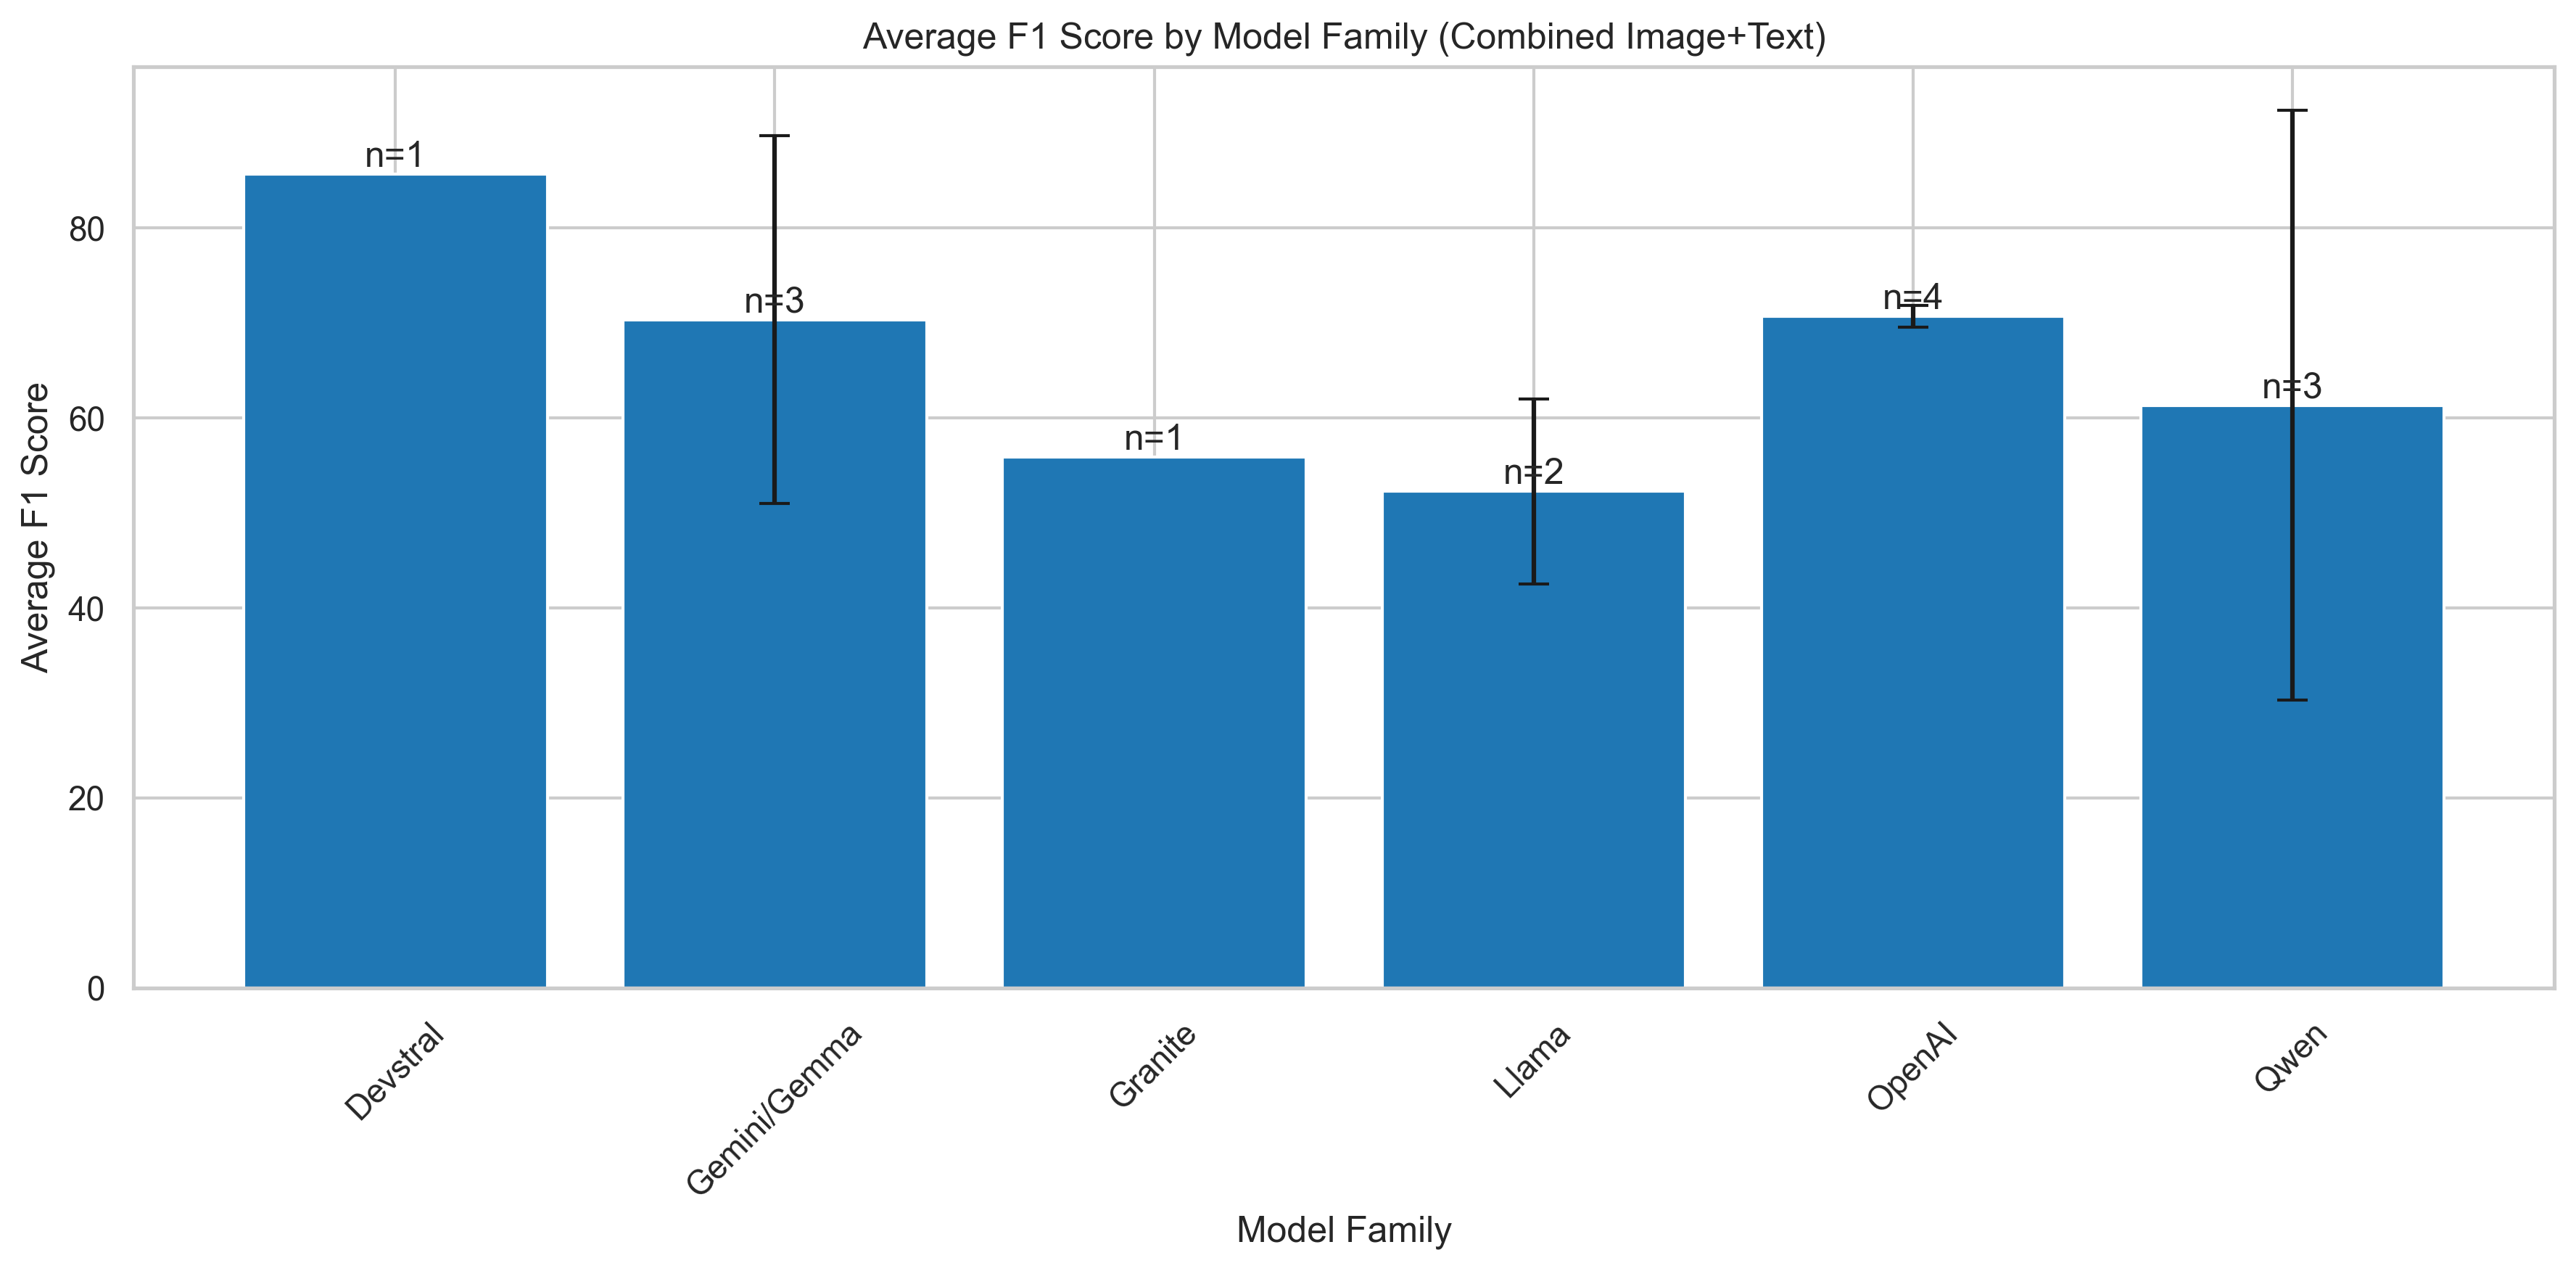

Family Statistics:
         Family  Mean_F1  Std_F1  Count
0      Devstral   85.693     NaN      1
1  Gemini/Gemma   70.363  19.342      3
2       Granite   55.921     NaN      1
3         Llama   52.292   9.748      2
4        OpenAI   70.707   1.146      4
5          Qwen   61.325  31.051      3


In [282]:
# Define model families including Llama, OpenAI, and Gemini/Gemma
def get_model_family(llm_name):
    llm_lower = llm_name.lower()
    if 'qwen' in llm_lower:
        return 'Qwen'
    elif 'llama' in llm_lower:
        return 'Llama'
    elif 'gpt' in llm_lower or 'openai' in llm_lower:
        return 'OpenAI'
    elif 'gemini' in llm_lower or 'gemma' in llm_lower:
        return 'Gemini/Gemma'
    elif 'granite' in llm_lower:
        return 'Granite'
    elif 'devstral' in llm_lower:
        return 'Devstral'
    else:
        return 'Other'

# Add family column to combined data
combined['Family'] = combined['LLM'].apply(get_model_family)
all_individual['Family'] = all_individual['LLM'].apply(get_model_family)

# Family comparison by F1 Score
family_comparison = combined.groupby('Family').agg({
    'F1score': ['mean', 'std', 'count']
}).round(3)
family_comparison.columns = ['Mean_F1', 'Std_F1', 'Count']
family_comparison = family_comparison.reset_index()

plt.figure(figsize=(12,6))
bars = plt.bar(family_comparison['Family'], family_comparison['Mean_F1'], 
               yerr=family_comparison['Std_F1'], capsize=5)
plt.title('Average F1 Score by Model Family (Combined Image+Text)')
plt.xlabel('Model Family')
plt.ylabel('Average F1 Score')
plt.xticks(rotation=45)

# Add count labels on bars
for bar, count in zip(bars, family_comparison['Count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'n={count}', ha='center', va='bottom')

plt.tight_layout()
save_plot('06_average_f1_by_model_family')
plt.show()

print("Family Statistics:")
print(family_comparison)

Saved: 07_individual_family_breakdowns


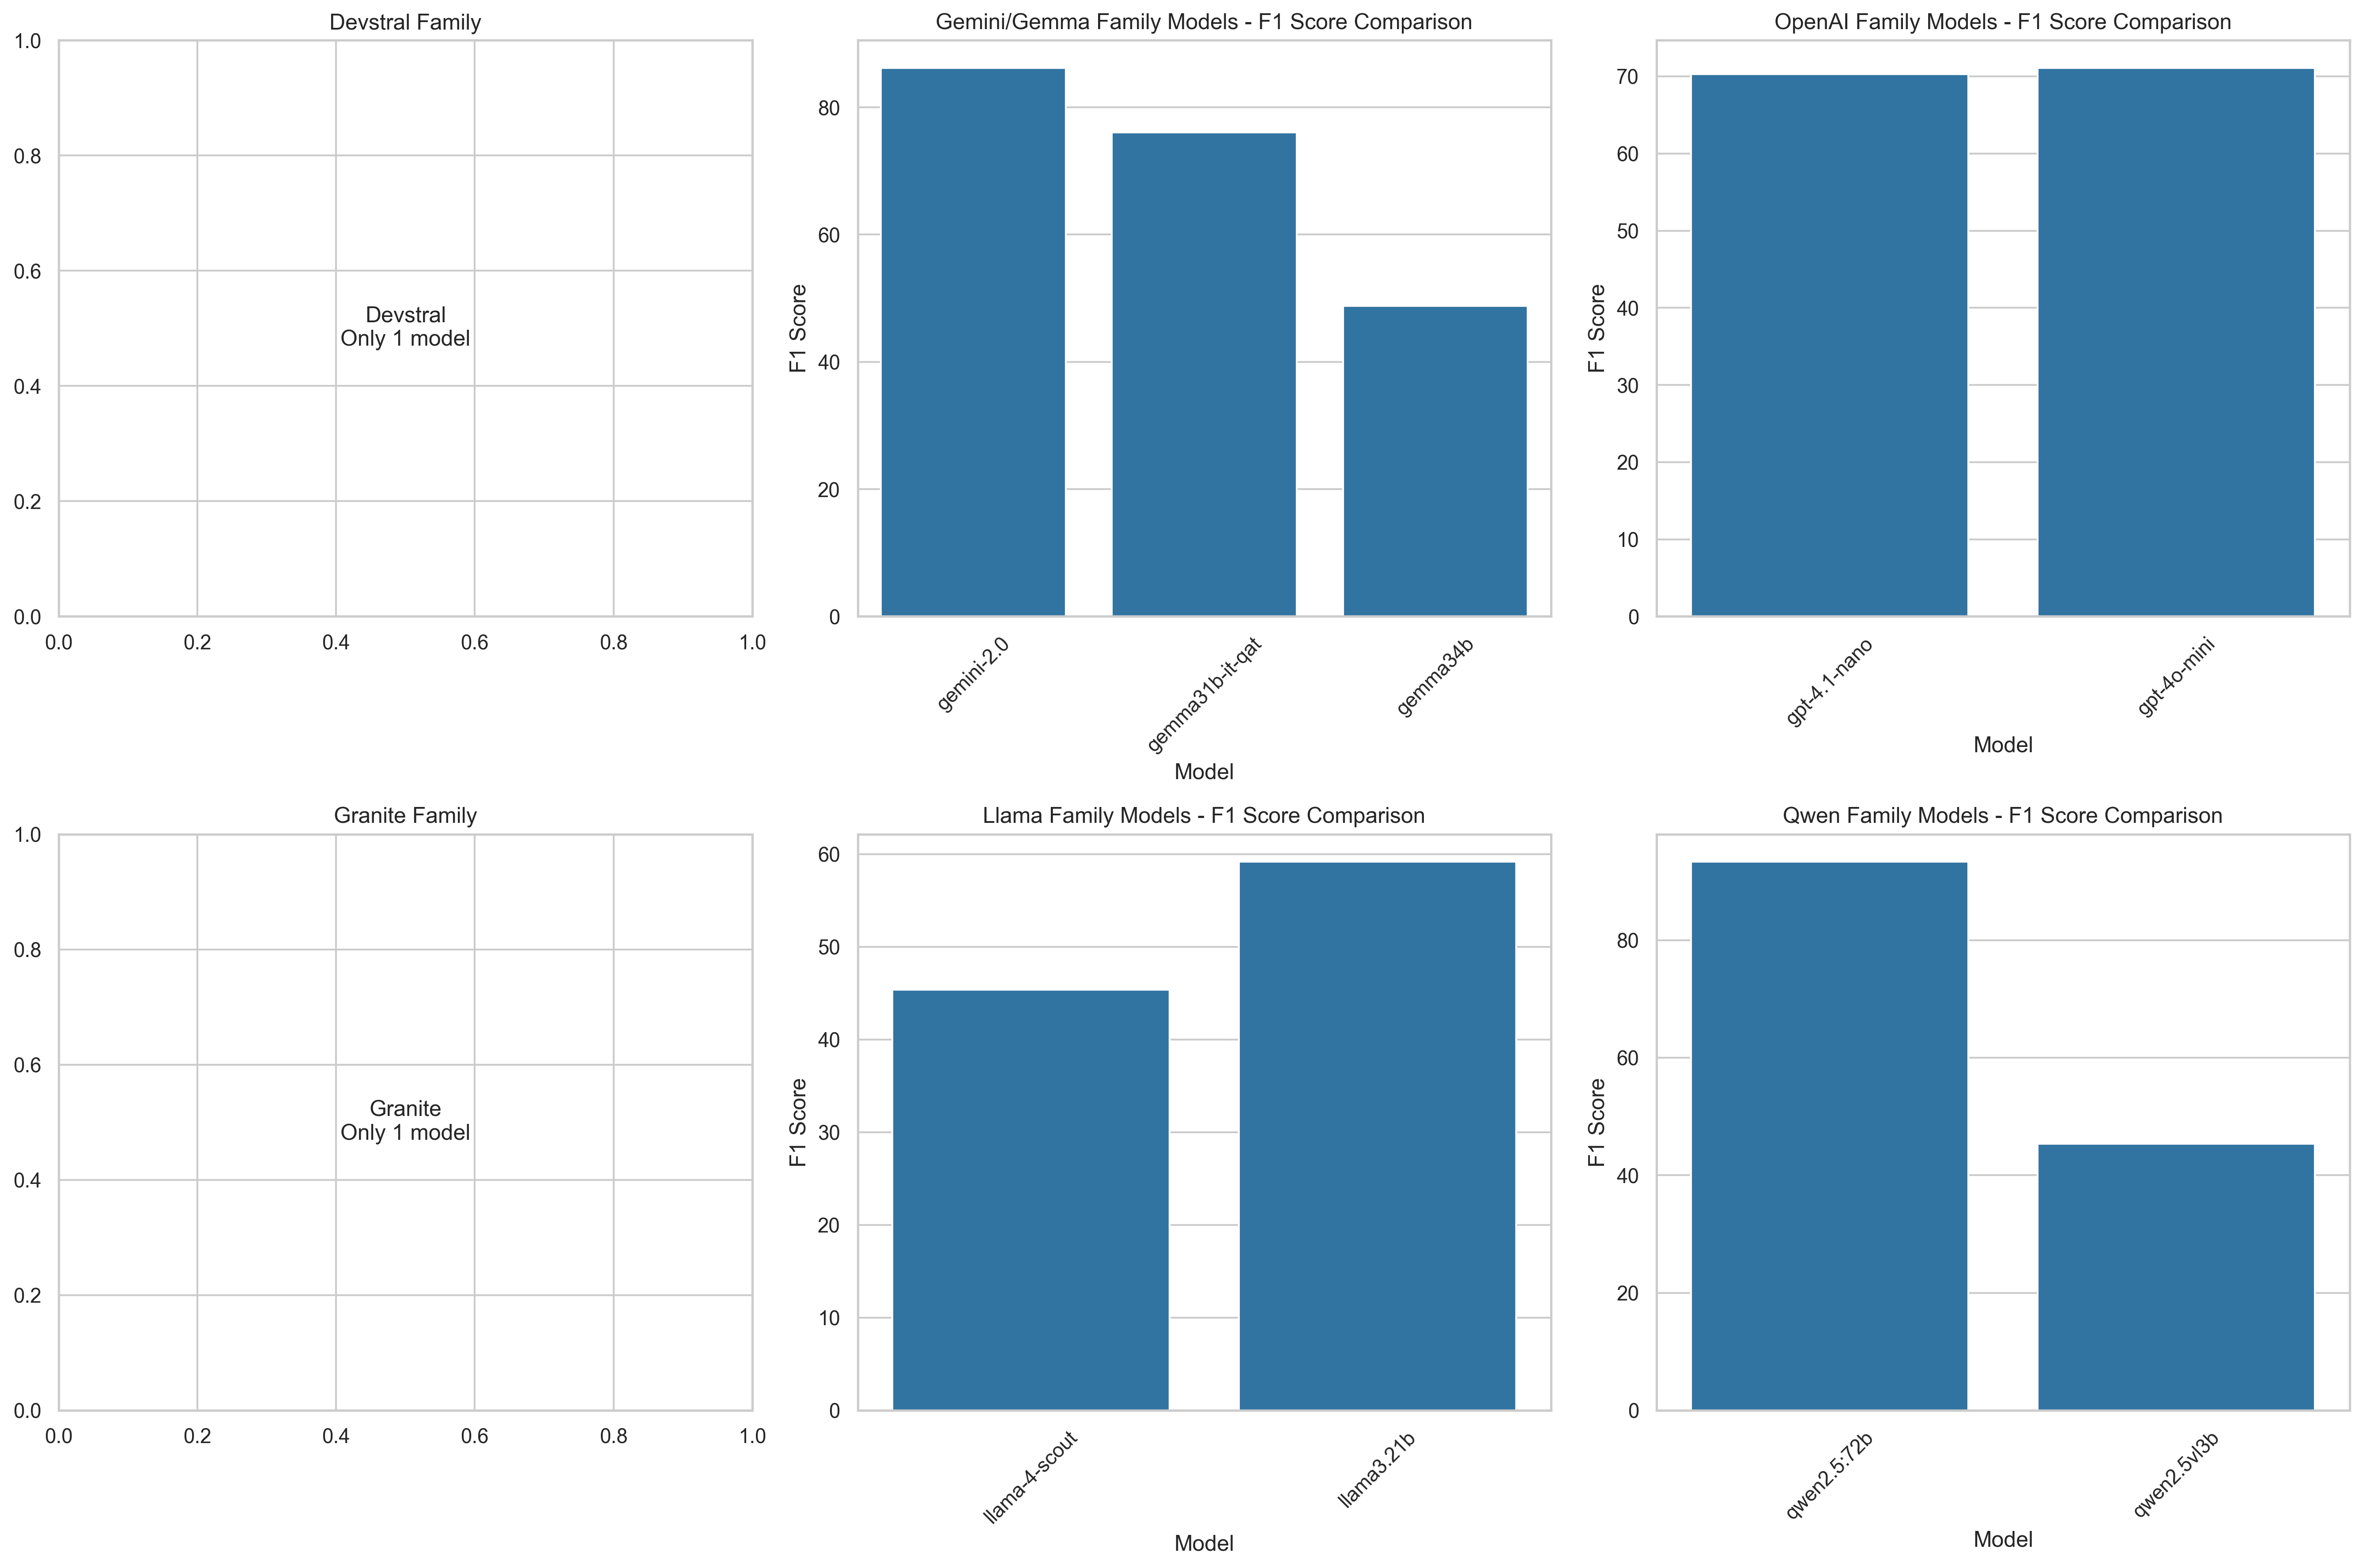

In [283]:
# Individual family breakdowns - create separate plots for each family
families = combined_norm['Family'].unique()

# Calculate number of subplots needed
n_families = len(families)
n_cols = 3
n_rows = (n_families + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, family in enumerate(families):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    family_data = combined_norm[combined_norm['Family'] == family]
    if len(family_data) > 1:  # Only plot if there are multiple models
        sns.barplot(data=family_data, x='LLM_normalized', y='F1score', ax=ax)
        ax.set_title(f'{family} Family Models - F1 Score Comparison')
        ax.set_xlabel('Model')
        ax.set_ylabel('F1 Score')
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.text(0.5, 0.5, f'{family}\nOnly 1 model', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{family} Family')

# Hide empty subplots
for i in range(n_families, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
save_plot('07_individual_family_breakdowns')
plt.show()

In [ ]:
# Side-by-side comparison of key metrics between hospitals
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.boxplot(data=all_individual, x='Hospital', y='Accuracy', ax=axes[0,0])
axes[0,0].set_title('Accuracy Distribution by Hospital')

sns.boxplot(data=all_individual, x='Hospital', y='F1score', ax=axes[0,1])
axes[0,1].set_title('F1 Score Distribution by Hospital')

sns.boxplot(data=all_individual, x='Hospital', y='Precision', ax=axes[1,0])
axes[1,0].set_title('Precision Distribution by Hospital')

sns.boxplot(data=all_individual, x='Hospital', y='Recall', ax=axes[1,1])
axes[1,1].set_title('Recall Distribution by Hospital')

plt.tight_layout()
save_plot('08_key_metrics_hospital_comparison')
plt.show()

In [ ]:
# Create a single PDF with all graphs
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create PDF filename with timestamp
pdf_filename = f'all_visualizations_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pdf'
pdf_path = os.path.join(output_dir, pdf_filename)

print(f"Creating combined PDF: {pdf_filename}")
print("This will recreate all graphs and save them to a single PDF...")

with PdfPages(pdf_path) as pdf:
    # 1. Accuracy Distribution (Normalized)
    plt.figure(figsize=(15,8))
    sns.boxplot(data=all_normalized, x='LLM_normalized', y='Accuracy')
    plt.xticks(rotation=90)
    plt.title('Accuracy Distribution Across All Models (Combined Image+Text Versions)')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 2. F1 Score Hospital Comparison (Normalized)
    plt.figure(figsize=(16,8))
    sns.barplot(data=all_normalized, x='LLM_normalized', y='F1score', hue='Hospital')
    plt.xticks(rotation=90)
    plt.title('F1 Score Comparison by Model and Hospital (Combined Image+Text Versions)')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 3. False Positives/Negatives Comparison
    melted = combined.melt(id_vars='LLM', value_vars=['False Positives','False Negatives'], var_name='Error Type', value_name='Average')
    plt.figure(figsize=(15,8))
    sns.barplot(data=melted, x='LLM', y='Average', hue='Error Type')
    plt.xticks(rotation=90)
    plt.title('Average False Positives and False Negatives by Model')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 4. Image Input vs No Image Comparison
    all_individual['Has_Image_Input'] = all_individual['LLM'].str.contains('ImageInput', case=False)
    img_comparison = all_individual.groupby(['Hospital', 'Has_Image_Input']).agg({
        'Accuracy': 'mean',
        'F1score': 'mean',
        'False Positives': 'mean',
        'False Negatives': 'mean'
    }).reset_index()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    sns.barplot(data=img_comparison, x='Hospital', y='Accuracy', hue='Has_Image_Input', ax=axes[0,0])
    axes[0,0].set_title('Average Accuracy: Image Input vs No Image')
    sns.barplot(data=img_comparison, x='Hospital', y='F1score', hue='Has_Image_Input', ax=axes[0,1])
    axes[0,1].set_title('Average F1 Score: Image Input vs No Image')
    sns.barplot(data=img_comparison, x='Hospital', y='False Positives', hue='Has_Image_Input', ax=axes[1,0])
    axes[1,0].set_title('Average False Positives: Image Input vs No Image')
    sns.barplot(data=img_comparison, x='Hospital', y='False Negatives', hue='Has_Image_Input', ax=axes[1,1])
    axes[1,1].set_title('Average False Negatives: Image Input vs No Image')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 5. F1 Scores by Hospital (Separate Bars)
    hospital1_f1 = hospital1.set_index('LLM')['F1score']
    hospital2_f1 = hospital2.set_index('LLM')['F1score']
    x = np.arange(len(hospital1_f1))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(16, 8))
    bars1 = ax.bar(x - width/2, hospital1_f1.values, width, label='Hospital 1', color=colors[0])
    bars2 = ax.bar(x + width/2, hospital2_f1.values, width, label='Hospital 2', color=colors[1])
    ax.set_xlabel('LLM Model')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores by Hospital and LLM Model')
    ax.set_xticks(x)
    ax.set_xticklabels(hospital1_f1.index, rotation=90)
    ax.legend()
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 6. Average F1 by Model Family
    if 'Family' not in combined.columns:
        combined['Family'] = combined['LLM'].apply(get_model_family)
    family_comparison = combined.groupby('Family').agg({
        'F1score': ['mean', 'std', 'count']
    }).round(3)
    family_comparison.columns = ['Mean_F1', 'Std_F1', 'Count']
    family_comparison = family_comparison.reset_index()
    
    plt.figure(figsize=(12,6))
    bars = plt.bar(family_comparison['Family'], family_comparison['Mean_F1'], 
                   yerr=family_comparison['Std_F1'], capsize=5)
    plt.title('Average F1 Score by Model Family')
    plt.xlabel('Model Family')
    plt.ylabel('Average F1 Score')
    plt.xticks(rotation=45)
    for bar, count in zip(bars, family_comparison['Count']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'n={count}', ha='center', va='bottom')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 7. Individual Family Breakdowns
    if 'combined_norm' in locals():
        families = combined_norm['Family'].unique()
        n_families = len(families)
        n_cols = 3
        n_rows = (n_families + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, family in enumerate(families):
            row = i // n_cols
            col = i % n_cols
            ax = axes[row, col]
            family_data = combined_norm[combined_norm['Family'] == family]
            if len(family_data) > 1:
                sns.barplot(data=family_data, x='LLM_normalized', y='F1score', ax=ax)
                ax.set_title(f'{family} Family Models - F1 Score Comparison')
                ax.set_xlabel('Model')
                ax.set_ylabel('F1 Score')
                ax.tick_params(axis='x', rotation=45)
            else:
                ax.text(0.5, 0.5, f'{family}\\nOnly 1 model', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{family} Family')
        
        for i in range(n_families, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight')
        plt.close()
    
    # 8. Key Metrics Hospital Comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    sns.boxplot(data=all_individual, x='Hospital', y='Accuracy', ax=axes[0,0])
    axes[0,0].set_title('Accuracy Distribution by Hospital')
    sns.boxplot(data=all_individual, x='Hospital', y='F1score', ax=axes[0,1])
    axes[0,1].set_title('F1 Score Distribution by Hospital')
    sns.boxplot(data=all_individual, x='Hospital', y='Precision', ax=axes[1,0])
    axes[1,0].set_title('Precision Distribution by Hospital')
    sns.boxplot(data=all_individual, x='Hospital', y='Recall', ax=axes[1,1])
    axes[1,1].set_title('Recall Distribution by Hospital')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 9. Error Analysis - FP/FN
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.boxplot(data=all_individual, x='Hospital', y='False Positives', ax=axes[0])
    axes[0].set_title('False Positives Distribution by Hospital')
    sns.boxplot(data=all_individual, x='Hospital', y='False Negatives', ax=axes[1])
    axes[1].set_title('False Negatives Distribution by Hospital')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 10. Correlation Scatter Matrix
    metrics = ['Accuracy', 'F1score', 'Precision', 'Recall']
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for i, metric1 in enumerate(metrics[:2]):
        for j, metric2 in enumerate(metrics[2:]):
            sns.scatterplot(data=all_individual, x=metric1, y=metric2, hue='Hospital', ax=axes[i,j])
            axes[i,j].set_title(f'{metric1} vs {metric2}')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 11. Model Source Comparison
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=all_individual, x='Source', y='F1score', hue='Hospital')
    plt.title('F1 Score Distribution by Model Source and Hospital')
    plt.xticks(rotation=45)
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    # 12. Performance Heatmap
    pivot_data = all_individual.groupby(['Hospital', 'Source'])[['Accuracy', 'F1score', 'Precision', 'Recall']].mean().reset_index()
    pivot_table = pivot_data.pivot(index='Hospital', columns='Source', values='F1score')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdYlBu_r', fmt='.3f')
    plt.title('Average F1 Score Heatmap: Hospital vs Model Source')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    plt.close()

print(f"\n✅ Combined PDF created successfully!")
print(f"📁 Location: {pdf_path}")
print(f"📊 Contains: 12 visualization pages")
print(f"📄 File size: {os.path.getsize(pdf_path) / (1024*1024):.1f} MB")